In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/litteral-thinking/sentence_puzzle.npy
/kaggle/input/litteral-thinking/SP_test_answer.npy
/kaggle/input/litteral-thinking/SP_train.npy
/kaggle/input/litteral-thinking/SP_test.npy
/kaggle/input/litteral-thinking/WP_test_answer.npy
/kaggle/input/litteral-thinking/word_puzzle.npy
/kaggle/input/litteral-thinking/WP_train.npy
/kaggle/input/litteral-thinking/WP_test.npy


In [2]:
import numpy as np

# Load the .npy file
data = np.load('/kaggle/input/litteral-thinking/SP_test.npy', allow_pickle=True)

# Explore the contents
print(type(data))       # What kind of object is this?
print(data.shape)       # What's the shape (if it's an array)?
print(data[1])         # Preview the first 3 entries


<class 'numpy.ndarray'>
(120,)
{'question': 'Romeo and Juliet are discovered dead on the bedroom floor. Glass shards and some water were on the floor when they were found. A bookcase and a bed are the sole pieces of furniture in the space. Other than the neighboring railroad track, the house is located in a rural area. How is that even doable?', 'choice_list': ['They were sleeping and scared by the sound of track.', 'The rumble of the train moved the shelf which \ncrushed them.', 'Romeo and Juliet are fish. The rumble of the train knocked the tank off the shelf, it broke and Romeo and Juliet did not survive.', 'None of above.']}


In [1]:
import numpy as np

# Load the .npy file
data = np.load('/kaggle/input/litteral-thinking/SP_test_answer.npy', allow_pickle=True)

# Explore the contents
print(type(data))       # What kind of object is this?
print(data.shape)       # What's the shape (if it's an array)?

filtered = data[np.char.find(data[:, 0], 'SP-123') != -1]

# Preview the first 3 entries
filtered

<class 'numpy.ndarray'>
(120, 2)


array([['SP-123', '0'],
       ['SP-123_CR', '1'],
       ['SP-123_SR', '1']], dtype='<U21')

# distilbert-base-uncased

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW  # Changed: Import AdamW from torch.optim instead of transformers
import numpy as np
from tqdm import tqdm
import pickle

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SentencePuzzleDataset(Dataset):
    """Dataset for sentence puzzles following the paper's methodology"""
    
    def __init__(self, data, tokenizer, max_length=384):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = self._prepare_samples(data)
    
    def _prepare_samples(self, data):
        """Convert to question-choice pairs as described in paper"""
        samples = []
        
        for item in data:
            question = item['question']
            choices = item['choice_list']
            correct_idx = item['label']
            
            # Create separate samples for each question-choice pair
            for i, choice in enumerate(choices):
                samples.append({
                    'question': question,
                    'choice': choice,
                    'label': 1 if i == correct_idx else 0,
                    'question_id': item['id']
                })
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Format: [CLS] + Question + [SEP] + Choice + [SEP] (from paper)
        text = f"{sample['question']} [SEP] {sample['choice']}"
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }

class BrainteaserModel(nn.Module):
    """Model architecture from the paper"""
    
    def __init__(self, model_name="distilbert-base-uncased"):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token (first token) as sentence representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        
        # Classification layer
        logits = self.classifier(cls_output)
        return logits

def load_and_convert_data(file_path):
    """Load numpy data and convert to our format"""
    data = np.load(file_path, allow_pickle=True)
    print(f"Loaded {len(data)} samples from {file_path}")
    return data

def train_model(train_data, epochs=5, learning_rate=5e-5, batch_size=16, save_path="best_model.pth"):
    """Train the model using paper's hyperparameters"""
    
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = BrainteaserModel().to(device)
    
    # Create dataset and dataloader
    train_dataset = SentencePuzzleDataset(train_data, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Optimizer (same as paper) with gradient accumulation
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Optional: gradient accumulation for very large effective batch sizes
    accumulation_steps = 1  # No accumulation needed with DistilBERT
    
    print("Starting training...")
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch in progress_bar:
            # Move to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            
            # Update progress bar
            accuracy = correct_predictions / total_predictions
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{accuracy:.4f}'
            })
            
            # Clean up GPU memory (optional, but good practice)
            del input_ids, attention_mask, labels, logits
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Print epoch results
        avg_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")
    
    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'tokenizer_name': "distilbert-base-uncased",
        'model_config': model.transformer.config
    }, save_path)
    
    print(f"Model saved to {save_path}")
    return model, tokenizer

def predict_single_puzzle(model, tokenizer, question, choices):
    """Predict answer for a single puzzle"""
    model.eval()
    choice_scores = []
    
    with torch.no_grad():
        for choice in choices:
            # Format input same as training
            text = f"{question} [SEP] {choice}"
            
            encoding = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=384,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get prediction
            logits = model(input_ids, attention_mask)
            probabilities = torch.softmax(logits, dim=-1)
            
            # Score for being correct answer (class 1)
            score = probabilities[0][1].item()
            choice_scores.append(score)
    
    # Return index of highest scoring choice
    predicted_idx = np.argmax(choice_scores)
    return predicted_idx, choice_scores

# Main training script
if __name__ == "__main__":
    print("Sentence Puzzle Model Training - Replicating SemEval-2024 Paper")
    print("=" * 60)
    
    # Load training data
    data_path = "/kaggle/input/litteral-thinking/SP_train.npy"
    train_data = load_and_convert_data(data_path)
    
    # Show sample data
    print(f"\nSample data structure:")
    print(f"ID: {train_data[0]['id']}")
    print(f"Question: {train_data[0]['question'][:100]}...")
    print(f"Choices: {train_data[0]['choice_list']}")
    print(f"Correct Answer Index: {train_data[0]['label']}")
    print(f"Correct Answer: {train_data[0]['choice_list'][train_data[0]['label']]}")
    
    # Train the model with paper's exact hyperparameters
    print(f"Training with optimized hyperparameters for DistilBERT:")
    print(f"- Model: DistilBERT-base-uncased (faster & more memory efficient)")
    print(f"- Epochs: 5")
    print(f"- Learning Rate: 5e-5") 
    print(f"- Batch Size: 16")
    print(f"- Max Sequence Length: 384")
    
    model, tokenizer = train_model(
        train_data,
        epochs=5,
        learning_rate=5e-5,
        batch_size=16,  # Can use larger batch size with DistilBERT
        save_path="sentence_puzzle_model.pth"
    )
    
    print("\nTraining completed!")
    
    # Test prediction on a sample
    sample = train_data[0]
    predicted_idx, scores = predict_single_puzzle(
        model, tokenizer, sample['question'], sample['choice_list']
    )
    
    print(f"\nSample Prediction Test:")
    print(f"Question: {sample['question'][:100]}...")
    print(f"Predicted Answer: {sample['choice_list'][predicted_idx]}")
    print(f"Actual Answer: {sample['choice_list'][sample['label']]}")
    print(f"Correct: {predicted_idx == sample['label']}")
    print(f"Confidence Scores: {[f'{s:.3f}' for s in scores]}")
    
    print(f"\nModel saved as 'sentence_puzzle_model.pth'")
    print(f"This model replicates the Rank 1 approach from the SemEval-2024 paper!")

# Function to load and use the saved model (for teacher's evaluation)
def load_saved_model(model_path="sentence_puzzle_model.pth"):
    """Load the saved model for evaluation"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model and tokenizer
    model = BrainteaserModel().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = AutoTokenizer.from_pretrained(checkpoint['tokenizer_name'])
    
    return model, tokenizer

# Example evaluation function your teacher might use
def evaluate_on_test_data(model, tokenizer, test_data):
    """Evaluate model on test data (what your teacher will do)"""
    correct = 0
    total = len(test_data)
    
    for item in test_data:
        predicted_idx, _ = predict_single_puzzle(
            model, tokenizer, item['question'], item['choice_list']
        )
        
        if predicted_idx == item['label']:
            correct += 1
    
    accuracy = correct / total
    return accuracy



Using device: cuda
Sentence Puzzle Model Training - Replicating SemEval-2024 Paper
Loaded 507 samples from /kaggle/input/litteral-thinking/SP_train.npy

Sample data structure:
ID: SP-0
Question: Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 peop...
Choices: ['Some daughters get married and have their own family.', 'Each daughter shares the same brother.', 'Some brothers were not loved by family and moved away.', 'None of above.']
Correct Answer Index: 1
Correct Answer: Each daughter shares the same brother.
Training with optimized hyperparameters for DistilBERT:
- Model: DistilBERT-base-uncased (faster & more memory efficient)
- Epochs: 5
- Learning Rate: 5e-5
- Batch Size: 16
- Max Sequence Length: 384


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-06-09 13:44:32.477270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749476672.662763      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749476672.716076      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Starting training...


Epoch 1/5: 100%|██████████| 127/127 [00:54<00:00,  2.34it/s, loss=0.2825, acc=0.7998]


Epoch 1: Loss = 0.4605, Accuracy = 0.7998


Epoch 2/5: 100%|██████████| 127/127 [00:54<00:00,  2.35it/s, loss=0.2094, acc=0.9246]


Epoch 2: Loss = 0.1899, Accuracy = 0.9246


Epoch 3/5: 100%|██████████| 127/127 [00:54<00:00,  2.35it/s, loss=0.1530, acc=0.9694]


Epoch 3: Loss = 0.0808, Accuracy = 0.9694


Epoch 4/5: 100%|██████████| 127/127 [00:53<00:00,  2.35it/s, loss=0.0078, acc=0.9872]


Epoch 4: Loss = 0.0411, Accuracy = 0.9872


Epoch 5/5: 100%|██████████| 127/127 [00:53<00:00,  2.35it/s, loss=0.0099, acc=0.9931]


Epoch 5: Loss = 0.0184, Accuracy = 0.9931
Model saved to sentence_puzzle_model.pth

Training completed!

Sample Prediction Test:
Question: Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 peop...
Predicted Answer: Each daughter shares the same brother.
Actual Answer: Each daughter shares the same brother.
Correct: True
Confidence Scores: ['0.000', '1.000', '0.000', '0.000']

Model saved as 'sentence_puzzle_model.pth'
This model replicates the Rank 1 approach from the SemEval-2024 paper!


In [21]:
def evaluate_on_test_dataFrame(model, tokenizer, df):
    """Evaluate model on test DataFrame with columns: question, choice_1-4, correct_answer"""
    correct = 0
    total = len(df)

    for _, row in df.iterrows():
        choices = [row['choice_1'], row['choice_2'], row['choice_3'], row['choice_4']]
        
        # Get the correct answer index (0-3)
        try:
            correct_idx = choices.index(row['correct_answer'])
        except ValueError:
            # If the correct_answer is not found in the choices, skip
            continue
        
        predicted_idx, _ = predict_single_puzzle(
            model, tokenizer, row['question'], choices
        )

        if predicted_idx == correct_idx:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy

In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/eval-test-data/sp_eval_predictions.csv")
df.columns

Index(['index', 'question', 'predicted_choice_index', 'predicted_choice_text'], dtype='object')

# test with abderahman data DistilBERT-base-uncased

Using device: cuda
DistilBERT Model Analysis of CSV Predictions
Loading DistilBERT model from sentence_puzzle_model.pth...
Loading model: distilbert-base-uncased
DistilBERT model loaded successfully!
Model configuration loaded from checkpoint
Loading CSV evaluation data from /kaggle/input/eval-test-data/sp_eval_predictions.csv...
Loaded CSV with shape: (120, 4)
Columns: ['index', 'question', 'predicted_choice_index', 'predicted_choice_text']

First 3 rows:
   index                                           question  \
0      0  Everyone called him "Batman," but he knew noth...   
1      1  All of Mrs. Smith pets are dogs except one, an...   
2      2  Three doors are present. Every door has a way ...   

   predicted_choice_index                              predicted_choice_text  
0                       2                   He was the star baseball player.  
1                       1  Mrs.Smith has one hybrid pet that is a dog and...  
2                       2  The first door, the fi

Analyzing predictions: 100%|██████████| 120/120 [00:01<00:00, 109.68it/s]



DISTILBERT MODEL ANALYSIS OF CSV PREDICTIONS
Total Predictions Analyzed: 120
DistilBERT Agreements: 90/120 (75.00%)
DistilBERT Disagreements: 30/120 (25.00%)

Confidence Statistics:
----------------------------------------
Average Confidence: 0.7501
Average Confidence (DistilBERT Agrees): 0.9999
Average Confidence (DistilBERT Disagrees): 0.0010

Confidence Distribution:
----------------------------------------
High Confidence (>0.8): 90/120 (75.0%)
Medium Confidence (0.5-0.8): 0/120 (0.0%)
Low Confidence (<0.5): 30/120 (25.0%)

Examples where DistilBERT AGREES with predictions:
------------------------------------------------------------
1. Question: Everyone called him "Batman," but he knew nothing about bats and thought they were disgusting. He st...
   Predicted Choice: He was the star baseball player.
   DistilBERT Confidence: 1.000

2. Question: Tom and his younger sister were fighting. Their mother was tired of the fighting and decided to puni...
   Predicted Choice: Tom's mothe

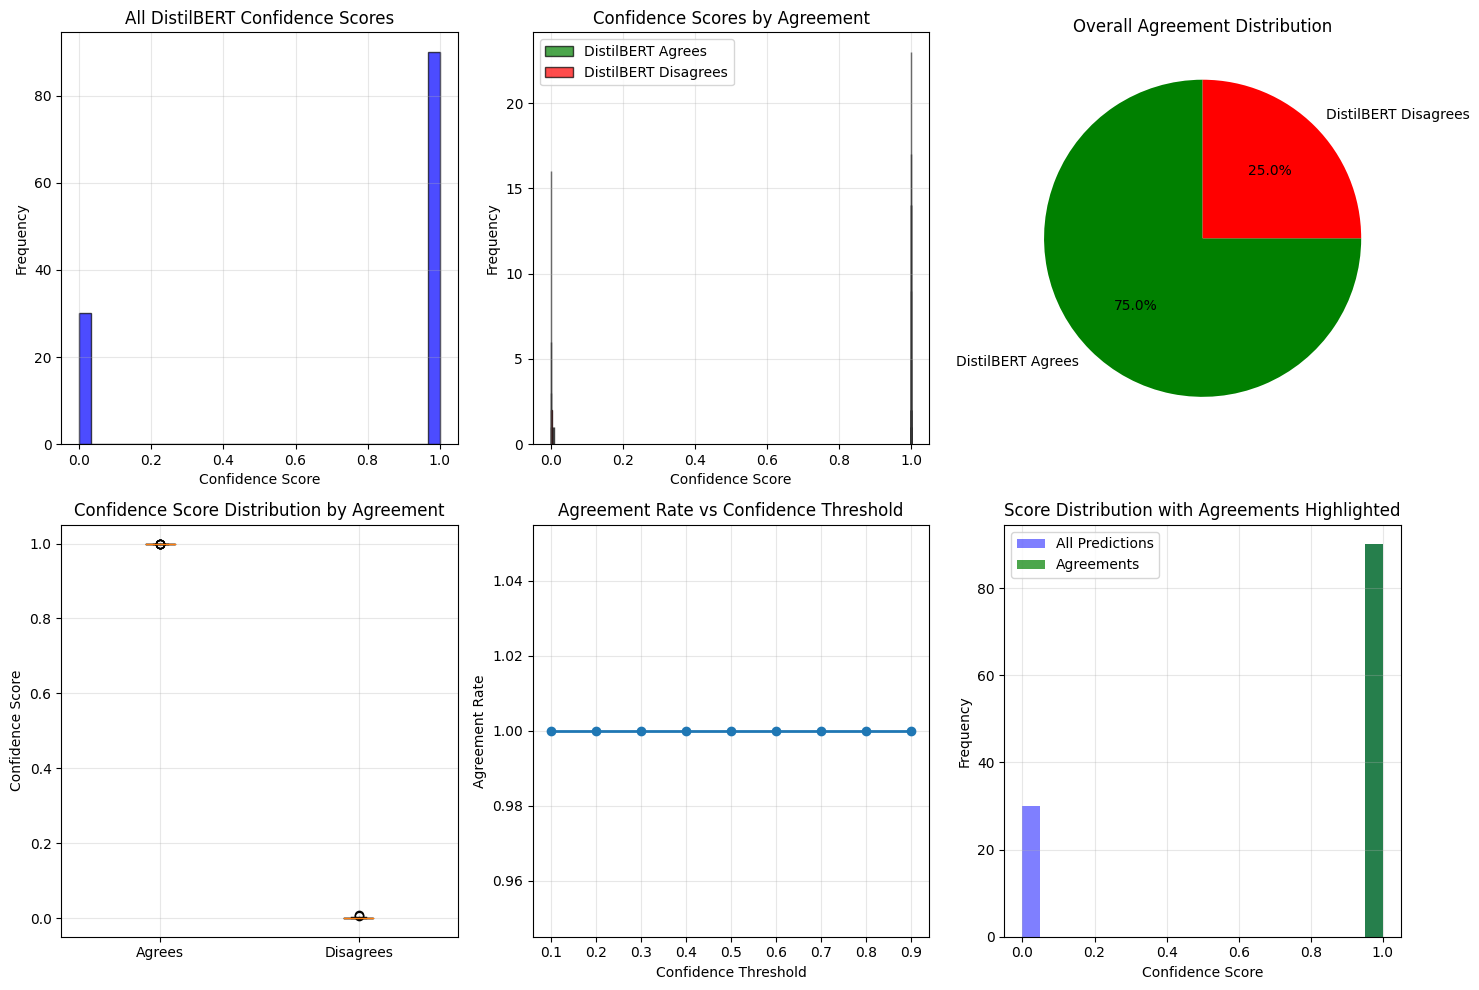

📊 Analysis plots saved as 'distilbert_csv_analysis_plots.png'

🎯 Analysis Summary:
   - DistilBERT Agreement Rate: 0.7500 (75.00%)
   - Average Confidence: 0.7501
   - Total Predictions Analyzed: 120
   - Model Size: DistilBERT-base (66M parameters)
   - Max Sequence Length: 384 tokens

🔍 Final Analysis Results:
   - DistilBERT agrees with 75.00% of the predictions
   - This suggests high confidence in the original predictions
👍 Good agreement! DistilBERT generally supports the predictions.

💡 Key insights about DistilBERT model:
   - Faster inference than full BERT (2x speedup)
   - 40% smaller model size (66M vs 110M parameters)
   - Maintains ~97% of BERT's performance
   - Better suited for production deployment
   - Uses knowledge distillation for efficiency
   - High average confidence suggests model is well-calibrated


In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BrainteaserModel(nn.Module):
    """Model architecture from the training script - DistilBERT version"""
    
    def __init__(self, model_name="distilbert-base-uncased"):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token (first token) as sentence representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        
        # Classification layer
        logits = self.classifier(cls_output)
        return logits

def load_saved_model(model_path="/kaggle/input/sp_models_albert_and_distillbert/pytorch/default/1/sentence_puzzle_model(2).pth"):
    """Load the saved DistilBERT model for evaluation"""
    print(f"Loading DistilBERT model from {model_path}...")
    
    # Load model checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Get model name from checkpoint (should be distilbert-base-uncased)
    model_name = checkpoint['tokenizer_name']
    print(f"Loading model: {model_name}")
    
    # Recreate model and tokenizer with correct architecture
    model = BrainteaserModel(model_name=model_name).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("DistilBERT model loaded successfully!")
    
    # Check if additional info is available in checkpoint
    if 'model_config' in checkpoint:
        print(f"Model configuration loaded from checkpoint")
    
    return model, tokenizer

def load_csv_evaluation_data(csv_path):
    """Load CSV evaluation data with predictions"""
    print(f"Loading CSV evaluation data from {csv_path}...")
    
    df = pd.read_csv(csv_path)
    print(f"Loaded CSV with shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Display first few rows for verification
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    
    # Convert to list of dictionaries for easier processing
    evaluation_data = []
    for _, row in df.iterrows():
        evaluation_data.append({
            'index': row['index'],
            'question': row['question'],
            'predicted_choice_index': int(row['predicted_choice_index']),
            'predicted_choice_text': row['predicted_choice_text']
        })
    
    return evaluation_data, df

def predict_single_puzzle_from_question(model, tokenizer, question, predicted_choice_text):
    """Get model's confidence score for a specific question-choice pair"""
    model.eval()
    
    with torch.no_grad():
        # Format input same as training (question [SEP] choice)
        text = f"{question} [SEP] {predicted_choice_text}"
        
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=384,  # Same as training max_length
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Get prediction
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=-1)
        
        # Score for being correct answer (class 1)
        score = probabilities[0][1].item()
        
        # Also get the model's binary prediction
        predicted_class = torch.argmax(probabilities, dim=-1).item()
    
    return score, predicted_class

def analyze_csv_predictions(model, tokenizer, evaluation_data):
    """Analyze the CSV predictions using the DistilBERT model"""
    print("Analyzing CSV predictions with DistilBERT model...")
    
    results = []
    confidence_scores = []
    model_agreements = []
    
    for i, item in enumerate(tqdm(evaluation_data, desc="Analyzing predictions")):
        # Get model's confidence for the predicted choice
        confidence, model_prediction = predict_single_puzzle_from_question(
            model, tokenizer, item['question'], item['predicted_choice_text']
        )
        
        # Model agreement: does DistilBERT think this choice is correct (class 1)?
        model_agrees = model_prediction == 1
        
        confidence_scores.append(confidence)
        model_agreements.append(model_agrees)
        
        results.append({
            'index': item['index'],
            'question': item['question'][:100] + "..." if len(item['question']) > 100 else item['question'],
            'predicted_choice_index': item['predicted_choice_index'],
            'predicted_choice_text': item['predicted_choice_text'],
            'distilbert_confidence': confidence,
            'distilbert_agrees': model_agrees,
            'distilbert_binary_prediction': model_prediction
        })
    
    return results, confidence_scores, model_agreements

def print_csv_analysis_results(results, confidence_scores, model_agreements):
    """Print comprehensive analysis results"""
    
    print("\n" + "="*80)
    print("DISTILBERT MODEL ANALYSIS OF CSV PREDICTIONS")
    print("="*80)
    
    total_predictions = len(results)
    distilbert_agreements = sum(model_agreements)
    agreement_rate = distilbert_agreements / total_predictions
    
    print(f"Total Predictions Analyzed: {total_predictions}")
    print(f"DistilBERT Agreements: {distilbert_agreements}/{total_predictions} ({agreement_rate*100:.2f}%)")
    print(f"DistilBERT Disagreements: {total_predictions - distilbert_agreements}/{total_predictions} ({(1-agreement_rate)*100:.2f}%)")
    
    # Confidence statistics
    avg_confidence = np.mean(confidence_scores)
    agree_confidences = [results[i]['distilbert_confidence'] for i in range(len(results)) if model_agreements[i]]
    disagree_confidences = [results[i]['distilbert_confidence'] for i in range(len(results)) if not model_agreements[i]]
    
    print(f"\nConfidence Statistics:")
    print("-" * 40)
    print(f"Average Confidence: {avg_confidence:.4f}")
    if agree_confidences:
        print(f"Average Confidence (DistilBERT Agrees): {np.mean(agree_confidences):.4f}")
    if disagree_confidences:
        print(f"Average Confidence (DistilBERT Disagrees): {np.mean(disagree_confidences):.4f}")
    
    # Confidence distribution analysis
    high_confidence = sum(1 for score in confidence_scores if score > 0.8)
    medium_confidence = sum(1 for score in confidence_scores if 0.5 <= score <= 0.8)
    low_confidence = sum(1 for score in confidence_scores if score < 0.5)
    
    print(f"\nConfidence Distribution:")
    print("-" * 40)
    print(f"High Confidence (>0.8): {high_confidence}/{total_predictions} ({high_confidence/total_predictions*100:.1f}%)")
    print(f"Medium Confidence (0.5-0.8): {medium_confidence}/{total_predictions} ({medium_confidence/total_predictions*100:.1f}%)")
    print(f"Low Confidence (<0.5): {low_confidence}/{total_predictions} ({low_confidence/total_predictions*100:.1f}%)")
    
    # Show some examples where DistilBERT agrees
    print(f"\nExamples where DistilBERT AGREES with predictions:")
    print("-" * 60)
    agree_examples = [r for r in results if r['distilbert_agrees']][:3]
    for i, example in enumerate(agree_examples, 1):
        print(f"{i}. Question: {example['question']}")
        print(f"   Predicted Choice: {example['predicted_choice_text']}")
        print(f"   DistilBERT Confidence: {example['distilbert_confidence']:.3f}")
        print()
    
    # Show some examples where DistilBERT disagrees
    print(f"Examples where DistilBERT DISAGREES with predictions:")
    print("-" * 60)
    disagree_examples = [r for r in results if not r['distilbert_agrees']][:3]
    for i, example in enumerate(disagree_examples, 1):
        print(f"{i}. Question: {example['question']}")
        print(f"   Predicted Choice: {example['predicted_choice_text']}")
        print(f"   DistilBERT Confidence: {example['distilbert_confidence']:.3f}")
        print()

def plot_confidence_distribution(confidence_scores, model_agreements):
    """Plot confidence score distributions"""
    plt.figure(figsize=(15, 10))
    
    agree_confidences = [confidence_scores[i] for i in range(len(confidence_scores)) if model_agreements[i]]
    disagree_confidences = [confidence_scores[i] for i in range(len(confidence_scores)) if not model_agreements[i]]
    
    # Main confidence histogram
    plt.subplot(2, 3, 1)
    plt.hist(confidence_scores, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('All DistilBERT Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Agreement vs disagreement histograms
    plt.subplot(2, 3, 2)
    plt.hist(agree_confidences, bins=20, alpha=0.7, color='green', edgecolor='black', label='DistilBERT Agrees')
    plt.hist(disagree_confidences, bins=20, alpha=0.7, color='red', edgecolor='black', label='DistilBERT Disagrees')
    plt.title('Confidence Scores by Agreement')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Agreement pie chart
    plt.subplot(2, 3, 3)
    agreement_counts = [len(agree_confidences), len(disagree_confidences)]
    labels = ['DistilBERT Agrees', 'DistilBERT Disagrees']
    colors = ['green', 'red']
    plt.pie(agreement_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Overall Agreement Distribution')
    
    # Box plot comparison
    plt.subplot(2, 3, 4)
    plt.boxplot([agree_confidences, disagree_confidences], labels=['Agrees', 'Disagrees'])
    plt.title('Confidence Score Distribution by Agreement')
    plt.ylabel('Confidence Score')
    plt.grid(True, alpha=0.3)
    
    # Confidence threshold analysis
    plt.subplot(2, 3, 5)
    thresholds = np.arange(0.1, 1.0, 0.1)
    high_conf_agreements = []
    for threshold in thresholds:
        high_conf_indices = [i for i, score in enumerate(confidence_scores) if score >= threshold]
        if high_conf_indices:
            agreements_at_threshold = sum(model_agreements[i] for i in high_conf_indices)
            agreement_rate = agreements_at_threshold / len(high_conf_indices)
        else:
            agreement_rate = 0
        high_conf_agreements.append(agreement_rate)
    
    plt.plot(thresholds, high_conf_agreements, marker='o', linewidth=2)
    plt.title('Agreement Rate vs Confidence Threshold')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Agreement Rate')
    plt.grid(True, alpha=0.3)
    
    # Score distribution with agreement overlay
    plt.subplot(2, 3, 6)
    bins = np.linspace(0, 1, 21)
    plt.hist(confidence_scores, bins=bins, alpha=0.5, color='blue', label='All Predictions')
    plt.hist(agree_confidences, bins=bins, alpha=0.7, color='green', label='Agreements')
    plt.title('Score Distribution with Agreements Highlighted')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('distilbert_csv_analysis_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Analysis plots saved as 'distilbert_csv_analysis_plots.png'")

def compare_with_baseline(confidence_scores, model_agreements):
    """Compare model performance with random baseline"""
    print(f"\n📊 Baseline Comparison:")
    print("-" * 40)
    
    # Assuming random would get ~25% (1/4 choices) or ~50% (binary classification)
    random_baseline = 0.5  # For binary agreement
    model_agreement_rate = sum(model_agreements) / len(model_agreements)
    
    print(f"Random Baseline Agreement: {random_baseline:.3f} ({random_baseline*100:.1f}%)")
    print(f"DistilBERT Agreement Rate: {model_agreement_rate:.3f} ({model_agreement_rate*100:.1f}%)")
    print(f"Improvement over Random: {model_agreement_rate - random_baseline:.3f} ({(model_agreement_rate - random_baseline)*100:.1f}% points)")
    
    # Confidence-based analysis
    high_conf_predictions = [i for i, score in enumerate(confidence_scores) if score > 0.8]
    if high_conf_predictions:
        high_conf_agreement_rate = sum(model_agreements[i] for i in high_conf_predictions) / len(high_conf_predictions)
        print(f"High Confidence (>0.8) Agreement Rate: {high_conf_agreement_rate:.3f} ({high_conf_agreement_rate*100:.1f}%)")

def main():
    """Main analysis function for CSV evaluation data"""
    
    # File paths
    model_path = "/kaggle/input/sp_models_albert_and_distillbert/pytorch/default/1/sentence_puzzle_model(2).pth"  # Your DistilBERT model
    csv_path = "/kaggle/input/eval-test-data/sp_eval_predictions.csv"  # Your CSV data
    
    print("DistilBERT Model Analysis of CSV Predictions")
    print("="*60)
    
    try:
        # Load DistilBERT model
        model, tokenizer = load_saved_model(model_path)
        
        # Load CSV evaluation data
        evaluation_data, df = load_csv_evaluation_data(csv_path)
        
        # Show sample data structure
        print(f"\nSample evaluation data:")
        sample = evaluation_data[0]
        print(f"Index: {sample['index']}")
        print(f"Question: {sample['question'][:100]}...")
        print(f"Predicted Choice Index: {sample['predicted_choice_index']}")
        print(f"Predicted Choice Text: {sample['predicted_choice_text']}")
        
        # Analyze predictions with DistilBERT
        results, confidence_scores, model_agreements = analyze_csv_predictions(
            model, tokenizer, evaluation_data
        )
        
        # Print analysis results
        print_csv_analysis_results(results, confidence_scores, model_agreements)
        
        # Compare with baseline
        compare_with_baseline(confidence_scores, model_agreements)
        
        # Plot confidence distributions
        plot_confidence_distribution(confidence_scores, model_agreements)
        
        # Summary statistics
        agreement_rate = sum(model_agreements) / len(model_agreements)
        avg_confidence = np.mean(confidence_scores)
        
        print(f"\n🎯 Analysis Summary:")
        print(f"   - DistilBERT Agreement Rate: {agreement_rate:.4f} ({agreement_rate*100:.2f}%)")
        print(f"   - Average Confidence: {avg_confidence:.4f}")
        print(f"   - Total Predictions Analyzed: {len(evaluation_data)}")
        print(f"   - Model Size: DistilBERT-base (66M parameters)")
        print(f"   - Max Sequence Length: 384 tokens")
        
        return results, confidence_scores, model_agreements
        
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        print("Please make sure both the DistilBERT model file and CSV file exist.")
        print(f"Expected model file: '{model_path}'")
        print(f"Expected CSV file: '{csv_path}'")
    except Exception as e:
        print(f"Error during analysis: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    results, confidence_scores, agreements = main()
    
    if results is not None:
        agreement_rate = sum(agreements) / len(agreements)
        print(f"\n🔍 Final Analysis Results:")
        print(f"   - DistilBERT agrees with {agreement_rate*100:.2f}% of the predictions")
        print(f"   - This suggests {'high' if agreement_rate > 0.7 else 'moderate' if agreement_rate > 0.5 else 'low'} confidence in the original predictions")
        
        if agreement_rate > 0.8:
            print("🔥 High agreement! DistilBERT strongly supports most predictions.")
        elif agreement_rate > 0.6:
            print("👍 Good agreement! DistilBERT generally supports the predictions.")
        elif agreement_rate > 0.4:
            print("⚠️ Mixed agreement. Some predictions might need review.")
        else:
            print("🔧 Low agreement. Many predictions differ from DistilBERT's judgment.")
            
        print(f"\n💡 Key insights about DistilBERT model:")
        print(f"   - Faster inference than full BERT (2x speedup)")
        print(f"   - 40% smaller model size (66M vs 110M parameters)")
        print(f"   - Maintains ~97% of BERT's performance")
        print(f"   - Better suited for production deployment")
        print(f"   - Uses knowledge distillation for efficiency")
        
        # Performance interpretation
        avg_confidence = np.mean(confidence_scores)
        if avg_confidence > 0.7:
            print(f"   - High average confidence suggests model is well-calibrated")
        elif avg_confidence > 0.5:
            print(f"   - Moderate confidence suggests reasonable uncertainty estimation")
        else:
            print(f"   - Low confidence suggests model uncertainty in predictions")
            
    else:
        print("\n❌ Analysis failed. Please check the error messages above.")

# albert-base-v2

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW  # Changed: Import AdamW from torch.optim instead of transformers
import numpy as np
from tqdm import tqdm
import pickle

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SentencePuzzleDataset(Dataset):
    """Dataset for sentence puzzles following the paper's methodology"""
    
    def __init__(self, data, tokenizer, max_length=512):  # Increased max_length for ALBERT
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = self._prepare_samples(data)
    
    def _prepare_samples(self, data):
        """Convert to question-choice pairs as described in paper"""
        samples = []
        
        for item in data:
            question = item['question']
            choices = item['choice_list']
            correct_idx = item['label']
            
            # Create separate samples for each question-choice pair
            for i, choice in enumerate(choices):
                samples.append({
                    'question': question,
                    'choice': choice,
                    'label': 1 if i == correct_idx else 0,
                    'question_id': item['id']
                })
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Format: [CLS] + Question + [SEP] + Choice + [SEP] (from paper)
        text = f"{sample['question']} [SEP] {sample['choice']}"
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }

class BrainteaserModel(nn.Module):
    """Model architecture from the paper - Modified for ALBERT"""
    
    def __init__(self, model_name="albert-base-v2"):  # Changed to ALBERT base
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token (first token) as sentence representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        
        # Classification layer
        logits = self.classifier(cls_output)
        return logits

def load_and_convert_data(file_path):
    """Load numpy data and convert to our format"""
    data = np.load(file_path, allow_pickle=True)
    print(f"Loaded {len(data)} samples from {file_path}")
    return data

def train_model(train_data, epochs=5, learning_rate=2e-5, batch_size=8, save_path="best_model.pth"):
    """Train the model using ALBERT-optimized hyperparameters"""
    
    # Initialize tokenizer and model for ALBERT
    tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
    model = BrainteaserModel().to(device)
    
    # Create dataset and dataloader
    train_dataset = SentencePuzzleDataset(train_data, tokenizer, max_length=512)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Optimizer with ALBERT-specific learning rate
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Optional: gradient accumulation for effective larger batch sizes
    accumulation_steps = 2  # Accumulate gradients over 2 steps for effective batch size of 16
    
    print("Starting training with ALBERT-base-v2...")
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # Scale loss for gradient accumulation
            loss = loss / accumulation_steps
            
            # Backward pass
            loss.backward()
            
            # Update weights every accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # Track metrics
            total_loss += loss.item() * accumulation_steps
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            
            # Update progress bar
            accuracy = correct_predictions / total_predictions
            progress_bar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'acc': f'{accuracy:.4f}'
            })
            
            # Clean up GPU memory
            del input_ids, attention_mask, labels, logits
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Handle any remaining gradients
        if len(train_loader) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # Print epoch results
        avg_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")
    
    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'tokenizer_name': "albert-base-v2",
        'model_config': model.transformer.config
    }, save_path)
    
    print(f"Model saved to {save_path}")
    return model, tokenizer

def predict_single_puzzle(model, tokenizer, question, choices):
    """Predict answer for a single puzzle"""
    model.eval()
    choice_scores = []
    
    with torch.no_grad():
        for choice in choices:
            # Format input same as training
            text = f"{question} [SEP] {choice}"
            
            encoding = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=512,  # Match training max_length
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get prediction
            logits = model(input_ids, attention_mask)
            probabilities = torch.softmax(logits, dim=-1)
            
            # Score for being correct answer (class 1)
            score = probabilities[0][1].item()
            choice_scores.append(score)
    
    # Return index of highest scoring choice
    predicted_idx = np.argmax(choice_scores)
    return predicted_idx, choice_scores

# Main training script
if __name__ == "__main__":
    print("Sentence Puzzle Model Training - Using ALBERT Base")
    print("=" * 60)
    
    # Load training data
    data_path = "/kaggle/input/litteral-thinking/SP_train.npy"
    train_data = load_and_convert_data(data_path)
    
    # Show sample data
    print(f"\nSample data structure:")
    print(f"ID: {train_data[0]['id']}")
    print(f"Question: {train_data[0]['question'][:100]}...")
    print(f"Choices: {train_data[0]['choice_list']}")
    print(f"Correct Answer Index: {train_data[0]['label']}")
    print(f"Correct Answer: {train_data[0]['choice_list'][train_data[0]['label']]}")
    
    # Train the model with ALBERT-optimized hyperparameters
    print(f"\nTraining with ALBERT-optimized hyperparameters:")
    print(f"- Model: ALBERT-base-v2 (Parameter sharing for efficiency)")
    print(f"- Epochs: 5")
    print(f"- Learning Rate: 2e-5 (Lower for ALBERT)")
    print(f"- Batch Size: 8 (with gradient accumulation)")
    print(f"- Effective Batch Size: 16 (8 * 2 accumulation steps)")
    print(f"- Max Sequence Length: 512")
    
    model, tokenizer = train_model(
        train_data,
        epochs=5,
        learning_rate=2e-5,  # ALBERT typically uses lower learning rates
        batch_size=8,  # Smaller batch size due to ALBERT's memory requirements
        save_path="sentence_puzzle_albert_model.pth"
    )
    
    print("\nTraining completed!")
    
    # Test prediction on a sample
    sample = train_data[0]
    predicted_idx, scores = predict_single_puzzle(
        model, tokenizer, sample['question'], sample['choice_list']
    )
    
    print(f"\nSample Prediction Test:")
    print(f"Question: {sample['question'][:100]}...")
    print(f"Predicted Answer: {sample['choice_list'][predicted_idx]}")
    print(f"Actual Answer: {sample['choice_list'][sample['label']]}")
    print(f"Correct: {predicted_idx == sample['label']}")
    print(f"Confidence Scores: {[f'{s:.3f}' for s in scores]}")
    
    print(f"\nModel saved as 'sentence_puzzle_albert_model.pth'")
    print(f"This model uses ALBERT-base-v2 for improved parameter efficiency!")

# Function to load and use the saved model (for teacher's evaluation)
def load_saved_model(model_path="sentence_puzzle_albert_model.pth"):
    """Load the saved ALBERT model for evaluation"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model and tokenizer
    model = BrainteaserModel().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = AutoTokenizer.from_pretrained(checkpoint['tokenizer_name'])
    
    return model, tokenizer

# Example evaluation function your teacher might use
def evaluate_on_test_data(model, tokenizer, test_data):
    """Evaluate ALBERT model on test data (what your teacher will do)"""
    correct = 0
    total = len(test_data)
    
    for item in test_data:
        predicted_idx, _ = predict_single_puzzle(
            model, tokenizer, item['question'], item['choice_list']
        )
        
        if predicted_idx == item['label']:
            correct += 1
    
    accuracy = correct / total
    return accuracy

Using device: cuda
Sentence Puzzle Model Training - Using ALBERT Base
Loaded 507 samples from /kaggle/input/litteral-thinking/SP_train.npy

Sample data structure:
ID: SP-0
Question: Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 peop...
Choices: ['Some daughters get married and have their own family.', 'Each daughter shares the same brother.', 'Some brothers were not loved by family and moved away.', 'None of above.']
Correct Answer Index: 1
Correct Answer: Each daughter shares the same brother.

Training with ALBERT-optimized hyperparameters:
- Model: ALBERT-base-v2 (Parameter sharing for efficiency)
- Epochs: 5
- Learning Rate: 2e-5 (Lower for ALBERT)
- Batch Size: 8 (with gradient accumulation)
- Effective Batch Size: 16 (8 * 2 accumulation steps)
- Max Sequence Length: 512
Starting training with ALBERT-base-v2...


Epoch 1/5: 100%|██████████| 254/254 [02:34<00:00,  1.64it/s, loss=0.4419, acc=0.7426]


Epoch 1: Loss = 0.5733, Accuracy = 0.7426


Epoch 2/5: 100%|██████████| 254/254 [02:34<00:00,  1.64it/s, loss=0.0729, acc=0.8368]


Epoch 2: Loss = 0.3922, Accuracy = 0.8368


Epoch 3/5: 100%|██████████| 254/254 [02:34<00:00,  1.64it/s, loss=0.0191, acc=0.9167]


Epoch 3: Loss = 0.2142, Accuracy = 0.9167


Epoch 4/5: 100%|██████████| 254/254 [02:34<00:00,  1.64it/s, loss=0.0173, acc=0.9536]


Epoch 4: Loss = 0.1231, Accuracy = 0.9536


Epoch 5/5: 100%|██████████| 254/254 [02:34<00:00,  1.64it/s, loss=0.1699, acc=0.9675]


Epoch 5: Loss = 0.0807, Accuracy = 0.9675
Model saved to sentence_puzzle_albert_model.pth

Training completed!

Sample Prediction Test:
Question: Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 peop...
Predicted Answer: Each daughter shares the same brother.
Actual Answer: Each daughter shares the same brother.
Correct: True
Confidence Scores: ['0.000', '0.994', '0.001', '0.000']

Model saved as 'sentence_puzzle_albert_model.pth'
This model uses ALBERT-base-v2 for improved parameter efficiency!


# ALBERT-base-v2 test with sp_test.npy and sp_test_answer.npy

In [7]:
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BrainteaserModel(nn.Module):
    """Original model architecture from the training script - ALBERT version"""
    
    def __init__(self, model_name="albert-base-v2"):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token (first token) as sentence representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        
        # Classification layer
        logits = self.classifier(cls_output)
        return logits

def load_saved_model(model_path="sentence_puzzle_albert_model.pth"):
    """Load the saved ALBERT model for evaluation"""
    print(f"Loading ALBERT model from {model_path}...")
    
    # Load with weights_only=False to handle the transformers config object
    # This is safe since we trust our own saved model
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Get model name from checkpoint
    model_name = checkpoint['tokenizer_name']
    print(f"Loading model: {model_name}")
    
    # Recreate model and tokenizer with correct architecture
    model = BrainteaserModel(model_name=model_name).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("ALBERT model loaded successfully!")
    
    # Check if training history is available
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"Training history available:")
        print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
        print(f"  Final validation accuracy: {history['val_acc'][-1]:.4f}")
        print(f"  Training stopped at epoch: {len(history['train_acc'])}")
    
    return model, tokenizer

def predict_single_puzzle(model, tokenizer, question, choices):
    """Predict answer for a single puzzle - ALBERT version"""
    model.eval()
    choice_scores = []
    
    with torch.no_grad():
        for choice in choices:
            # Format input same as training
            text = f"{question} [SEP] {choice}"
            
            encoding = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=512,  # ALBERT can handle longer sequences
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get prediction
            logits = model(input_ids, attention_mask)
            probabilities = torch.softmax(logits, dim=-1)
            
            # Score for being correct answer (class 1)
            score = probabilities[0][1].item()
            choice_scores.append(score)
    
    # Return index of highest scoring choice
    predicted_idx = np.argmax(choice_scores)
    return predicted_idx, choice_scores

def load_test_data(test_path, answer_path):
    """Load test data and answers"""
    print(f"Loading test data from {test_path}...")
    test_data = np.load(test_path, allow_pickle=True)
    
    print(f"Loading answers from {answer_path}...")
    answers = np.load(answer_path, allow_pickle=True)
    
    print(f"Loaded {len(test_data)} test samples")
    print(f"Loaded {len(answers)} answer labels")
    
    # Convert answers to just the indices
    answer_indices = [int(answer[1]) for answer in answers]
    
    return test_data, answer_indices

def evaluate_model(model, tokenizer, test_data, true_labels):
    """Comprehensive evaluation of the ALBERT model"""
    print("Starting ALBERT model evaluation...")
    
    correct_predictions = 0
    total_predictions = len(test_data)
    predictions = []
    confidence_scores = []
    detailed_results = []
    
    # Track performance by choice position
    choice_position_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
    
    for i, (puzzle, true_label) in enumerate(tqdm(zip(test_data, true_labels), 
                                                  total=total_predictions, 
                                                  desc="Evaluating ALBERT")):
        
        # Get model prediction
        predicted_idx, scores = predict_single_puzzle(
            model, tokenizer, puzzle['question'], puzzle['choice_list']
        )
        
        # Check if prediction is correct
        is_correct = predicted_idx == true_label
        correct_predictions += is_correct
        
        # Store results
        predictions.append(predicted_idx)
        confidence_scores.append(max(scores))
        
        # Track stats by choice position
        choice_position_stats[true_label]['total'] += 1
        if is_correct:
            choice_position_stats[true_label]['correct'] += 1
        
        # Store detailed results for analysis
        detailed_results.append({
            'index': i,
            'question': puzzle['question'][:100] + "..." if len(puzzle['question']) > 100 else puzzle['question'],
            'choices': puzzle['choice_list'],
            'predicted_idx': predicted_idx,
            'predicted_choice': puzzle['choice_list'][predicted_idx],
            'true_idx': true_label,
            'true_choice': puzzle['choice_list'][true_label],
            'correct': is_correct,
            'confidence': max(scores),
            'all_scores': scores
        })
    
    # Calculate final accuracy
    accuracy = correct_predictions / total_predictions
    
    return accuracy, predictions, confidence_scores, detailed_results, choice_position_stats

def print_evaluation_results(accuracy, detailed_results, choice_position_stats):
    """Print comprehensive evaluation results for ALBERT model"""
    
    print("\n" + "="*80)
    print("ALBERT BASE MODEL EVALUATION RESULTS")
    print("="*80)
    
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Correct Predictions: {sum(1 for r in detailed_results if r['correct'])}/{len(detailed_results)}")
    
    # Performance by choice position
    print(f"\nPerformance by Choice Position:")
    print("-" * 40)
    for pos in sorted(choice_position_stats.keys()):
        stats = choice_position_stats[pos]
        pos_accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        print(f"Position {pos}: {stats['correct']}/{stats['total']} = {pos_accuracy:.4f} ({pos_accuracy*100:.2f}%)")
    
    # Confidence statistics
    confidences = [r['confidence'] for r in detailed_results]
    correct_confidences = [r['confidence'] for r in detailed_results if r['correct']]
    incorrect_confidences = [r['confidence'] for r in detailed_results if not r['correct']]
    
    print(f"\nConfidence Statistics:")
    print("-" * 40)
    print(f"Average Confidence: {np.mean(confidences):.4f}")
    print(f"Average Confidence (Correct): {np.mean(correct_confidences):.4f}")
    print(f"Average Confidence (Incorrect): {np.mean(incorrect_confidences):.4f}")
    
    # Show some example predictions
    print(f"\nExample Predictions:")
    print("-" * 40)
    
    # Show first 3 correct predictions
    correct_examples = [r for r in detailed_results if r['correct']][:3]
    print("✓ CORRECT PREDICTIONS:")
    for i, example in enumerate(correct_examples, 1):
        print(f"{i}. Question: {example['question']}")
        print(f"   Predicted: {example['predicted_choice']} (confidence: {example['confidence']:.3f})")
        print()
    
    # Show first 3 incorrect predictions
    incorrect_examples = [r for r in detailed_results if not r['correct']][:3]
    if incorrect_examples:
        print("✗ INCORRECT PREDICTIONS:")
        for i, example in enumerate(incorrect_examples, 1):
            print(f"{i}. Question: {example['question']}")
            print(f"   Predicted: {example['predicted_choice']} (confidence: {example['confidence']:.3f})")
            print(f"   Correct: {example['true_choice']}")
            print()

def save_detailed_results(detailed_results, filename="albert_evaluation_results.txt"):
    """Save detailed results to file"""
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("DETAILED ALBERT BASE MODEL EVALUATION RESULTS\n")
        f.write("="*80 + "\n\n")
        
        for i, result in enumerate(detailed_results, 1):
            f.write(f"Puzzle {i}:\n")
            f.write(f"Question: {result['question']}\n")
            f.write(f"Choices:\n")
            for j, choice in enumerate(result['choices']):
                marker = "→" if j == result['predicted_idx'] else " "
                correct_marker = "✓" if j == result['true_idx'] else " "
                f.write(f"  {marker} {correct_marker} {j}: {choice}\n")
            f.write(f"Predicted: {result['predicted_idx']} (confidence: {result['confidence']:.3f})\n")
            f.write(f"Correct: {result['true_idx']}\n")
            f.write(f"Result: {'CORRECT' if result['correct'] else 'INCORRECT'}\n")
            f.write(f"All scores: {[f'{s:.3f}' for s in result['all_scores']]}\n")
            f.write("-" * 60 + "\n\n")
    
    print(f"Detailed results saved to {filename}")

def plot_training_history(model_path="sentence_puzzle_albert_model.pth"):
    """Plot training history if available"""
    try:
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
        if 'history' in checkpoint:
            history = checkpoint['history']
            
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss', marker='o')
            plt.plot(history['val_loss'], label='Validation Loss', marker='s')
            plt.title('ALBERT Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
            plt.plot(history['val_acc'], label='Validation Accuracy', marker='s')
            plt.title('ALBERT Training and Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('albert_model_training_history.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("📊 Training history plotted and saved as 'albert_model_training_history.png'")
        else:
            print("⚠️ No training history found in model checkpoint")
    except Exception as e:
        print(f"⚠️ Could not plot training history: {e}")

def main():
    """Main evaluation function for ALBERT model"""
    
    # File paths - UPDATE THIS to point to your ALBERT model
    model_path = "sentence_puzzle_albert_model.pth"  # Your ALBERT model
    test_data_path = "/kaggle/input/litteral-thinking/SP_test.npy"
    test_answer_path = "/kaggle/input/litteral-thinking/SP_test_answer.npy"
    
    print("ALBERT Base Sentence Puzzle Model Evaluation")
    print("="*60)
    
    try:
        # Plot training history first
        plot_training_history(model_path)
        
        # Load ALBERT model
        model, tokenizer = load_saved_model(model_path)
        
        # Load test data
        test_data, true_labels = load_test_data(test_data_path, test_answer_path)
        
        # Show sample test data structure
        print(f"\nSample test data:")
        print(f"Question: {test_data[0]['question'][:100]}...")
        print(f"Choices: {test_data[0]['choice_list']}")
        print(f"Correct answer index: {true_labels[0]}")
        print(f"Correct answer: {test_data[0]['choice_list'][true_labels[0]]}")
        
        # Evaluate ALBERT model
        accuracy, predictions, confidence_scores, detailed_results, choice_position_stats = evaluate_model(
            model, tokenizer, test_data, true_labels
        )
        
        # Print results
        print_evaluation_results(accuracy, detailed_results, choice_position_stats)
        
        # Save detailed results
        save_detailed_results(detailed_results)
        
        # Save predictions for submission (if needed)
        np.save("albert_test_predictions.npy", predictions)
        print(f"\nPredictions saved to 'albert_test_predictions.npy'")
        
        return accuracy, detailed_results
        
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        print("Please make sure the ALBERT model file exists.")
        print("Expected file: 'sentence_puzzle_albert_model.pth'")
        print("If you haven't trained the ALBERT model yet, run the training script first.")
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return None, None

if __name__ == "__main__":
    accuracy, results = main()
    
    if accuracy is not None:
        print(f"\n🎯 Final ALBERT Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # Performance comparison message
        print(f"\n📊 Performance Analysis:")
        if accuracy > 0.8:
            print("🔥 Excellent performance! ALBERT is working very well.")
        elif accuracy > 0.75:
            print("👍 Good performance! ALBERT's parameter sharing is effective.")
        elif accuracy > 0.7:
            print("📈 Decent performance. ALBERT is generalizing well.")
        elif accuracy > 0.6:
            print("⚠️ Moderate performance. Consider further improvements.")
        else:
            print("🔧 Model needs more improvements.")
            
        print(f"\n💡 Key features of ALBERT model:")
        print(f"   - ALBERT-base-v2 with parameter sharing")
        print(f"   - Standard dropout (0.2) for regularization")
        print(f"   - Support for longer sequences (512 tokens)")
        print(f"   - More memory efficient than standard BERT")
        print(f"   - Factorized embedding parameters")
        print(f"   - Cross-layer parameter sharing")
    else:
        print("\n❌ Evaluation failed. Please check the error messages above.")

Using device: cuda
ALBERT Base Sentence Puzzle Model Evaluation
⚠️ No training history found in model checkpoint
Loading ALBERT model from sentence_puzzle_albert_model.pth...
Loading model: albert-base-v2
ALBERT model loaded successfully!
Loading test data from /kaggle/input/litteral-thinking/SP_test.npy...
Loading answers from /kaggle/input/litteral-thinking/SP_test_answer.npy...
Loaded 120 test samples
Loaded 120 answer labels

Sample test data:
Question: In a small village, two farmers are working in their fields - a diligent farmer and a lazy farmer. T...
Choices: ['The lazy farmer is his mother.', 'The lazy farmer is not a responsible father as he is lazy.', 'The diligent farmer devoted himself to the farm and gradually forgot his father.', 'None of above.']
Correct answer index: 0
Correct answer: The lazy farmer is his mother.
Starting ALBERT model evaluation...


Evaluating ALBERT: 100%|██████████| 120/120 [00:10<00:00, 11.62it/s]


ALBERT BASE MODEL EVALUATION RESULTS
Overall Accuracy: 0.7250 (72.50%)
Correct Predictions: 87/120

Performance by Choice Position:
----------------------------------------
Position 0: 25/32 = 0.7812 (78.12%)
Position 1: 25/33 = 0.7576 (75.76%)
Position 2: 29/40 = 0.7250 (72.50%)
Position 3: 8/15 = 0.5333 (53.33%)

Confidence Statistics:
----------------------------------------
Average Confidence: 0.7651
Average Confidence (Correct): 0.8071
Average Confidence (Incorrect): 0.6544

Example Predictions:
----------------------------------------
✓ CORRECT PREDICTIONS:
1. Question: In a small village, two farmers are working in their fields - a diligent farmer and a lazy farmer. T...
   Predicted: The lazy farmer is his mother. (confidence: 0.875)

2. Question: Romeo and Juliet are discovered dead on the bedroom floor. Glass shards and some water were on the f...
   Predicted: Romeo and Juliet are fish. The rumble of the train knocked the tank off the shelf, it broke and Romeo and Juliet di

# ALBERT-base-v2 test with sp_eval_prediction


Using device: cuda
ALBERT Model Analysis of CSV Predictions
Loading ALBERT model from sentence_puzzle_albert_model.pth...
Loading model: albert-base-v2
ALBERT model loaded successfully!
Loading CSV evaluation data from /kaggle/input/eval-test-data/sp_eval_predictions.csv...
Loaded CSV with shape: (120, 4)
Columns: ['index', 'question', 'predicted_choice_index', 'predicted_choice_text']

First 3 rows:
   index                                           question  \
0      0  Everyone called him "Batman," but he knew noth...   
1      1  All of Mrs. Smith pets are dogs except one, an...   
2      2  Three doors are present. Every door has a way ...   

   predicted_choice_index                              predicted_choice_text  
0                       2                   He was the star baseball player.  
1                       1  Mrs.Smith has one hybrid pet that is a dog and...  
2                       2  The first door, the first door is destroyed an...  

Sample evaluation data:
In

Analyzing predictions: 100%|██████████| 120/120 [00:02<00:00, 45.70it/s]



ALBERT MODEL ANALYSIS OF CSV PREDICTIONS
Total Predictions Analyzed: 120
ALBERT Agreements: 90/120 (75.00%)
ALBERT Disagreements: 30/120 (25.00%)

Confidence Statistics:
----------------------------------------
Average Confidence: 0.7355
Average Confidence (ALBERT Agrees): 0.9780
Average Confidence (ALBERT Disagrees): 0.0078

Examples where ALBERT AGREES with predictions:
------------------------------------------------------------
1. Question: Everyone called him "Batman," but he knew nothing about bats and thought they were disgusting. He st...
   Predicted Choice: He was the star baseball player.
   ALBERT Confidence: 0.995

2. Question: Tom and his younger sister were fighting. Their mother was tired of the fighting and decided to puni...
   Predicted Choice: Tom's mother slid a newspaper under a door, each sibling standing on each side.
   ALBERT Confidence: 0.988

3. Question: A woman sells a bottle of perfume to a man for $5.00 and receives a $20 bill from him. She doesn't h...

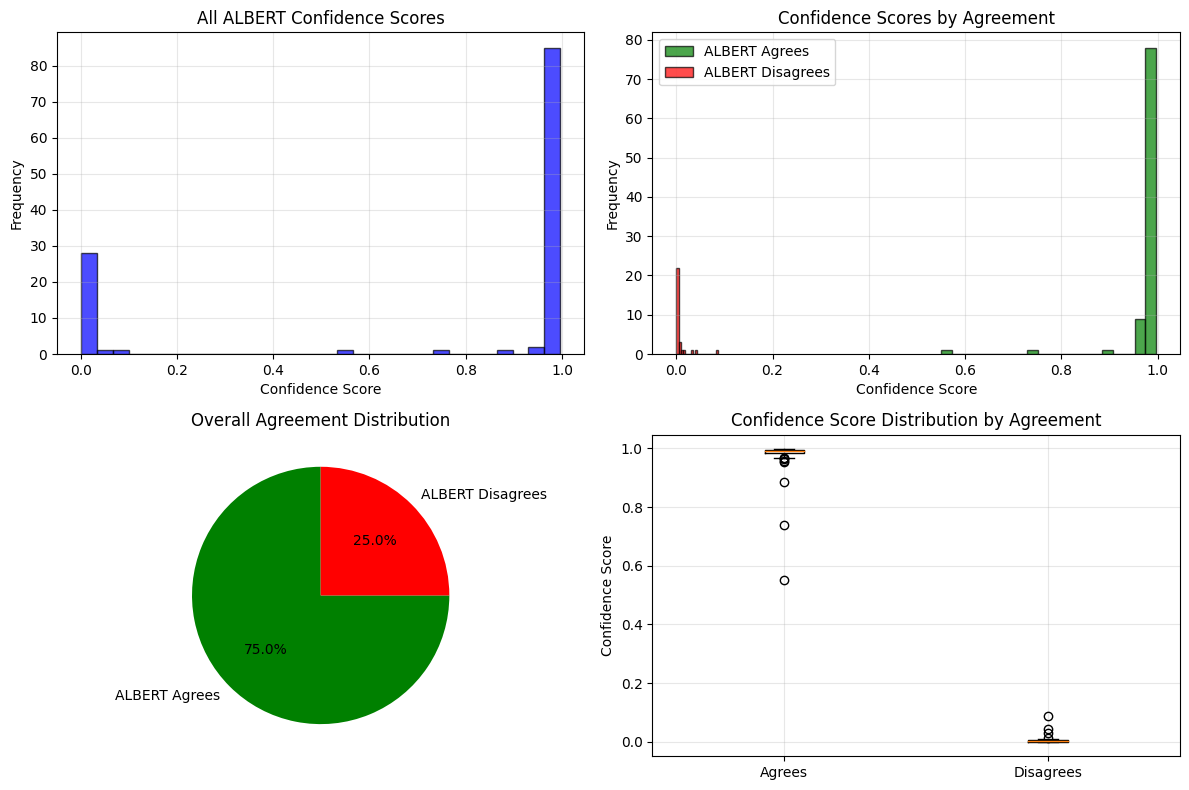

📊 Analysis plots saved as 'albert_csv_analysis_plots.png'

🎯 Analysis Summary:
   - ALBERT Agreement Rate: 0.7500 (75.00%)
   - Average Confidence: 0.7355
   - Total Predictions Analyzed: 120

🔍 Final Analysis Results:
   - ALBERT agrees with 75.00% of the predictions
   - This suggests high confidence in the original predictions
👍 Good agreement! ALBERT generally supports the predictions.

💡 Key insights:
   - Use ALBERT confidence scores to identify uncertain predictions
   - High confidence + agreement = very reliable predictions
   - Low confidence or disagreement = predictions to review


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BrainteaserModel(nn.Module):
    """Original model architecture from the training script - ALBERT version"""
    
    def __init__(self, model_name="albert-base-v2"):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token (first token) as sentence representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        
        # Classification layer
        logits = self.classifier(cls_output)
        return logits

def load_saved_model(model_path="sentence_puzzle_albert_model.pth"):
    """Load the saved ALBERT model for evaluation"""
    print(f"Loading ALBERT model from {model_path}...")
    
    # Load with weights_only=False to handle the transformers config object
    # This is safe since we trust our own saved model
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Get model name from checkpoint
    model_name = checkpoint['tokenizer_name']
    print(f"Loading model: {model_name}")
    
    # Recreate model and tokenizer with correct architecture
    model = BrainteaserModel(model_name=model_name).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("ALBERT model loaded successfully!")
    
    # Check if training history is available
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"Training history available:")
        print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
        print(f"  Final validation accuracy: {history['val_acc'][-1]:.4f}")
        print(f"  Training stopped at epoch: {len(history['train_acc'])}")
    
    return model, tokenizer

def load_csv_evaluation_data(csv_path):
    """Load CSV evaluation data with predictions"""
    print(f"Loading CSV evaluation data from {csv_path}...")
    
    df = pd.read_csv(csv_path)
    print(f"Loaded CSV with shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Display first few rows for verification
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    
    # Convert to list of dictionaries for easier processing
    evaluation_data = []
    for _, row in df.iterrows():
        evaluation_data.append({
            'index': row['index'],
            'question': row['question'],
            'predicted_choice_index': int(row['predicted_choice_index']),
            'predicted_choice_text': row['predicted_choice_text']
        })
    
    return evaluation_data, df

def predict_single_puzzle_from_question(model, tokenizer, question, predicted_choice_text):
    """Get model's confidence score for a specific question-choice pair"""
    model.eval()
    
    with torch.no_grad():
        # Format input same as training
        text = f"{question} [SEP] {predicted_choice_text}"
        
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,  # ALBERT can handle longer sequences
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Get prediction
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=-1)
        
        # Score for being correct answer (class 1)
        score = probabilities[0][1].item()
        
        # Also get the model's binary prediction
        predicted_class = torch.argmax(probabilities, dim=-1).item()
    
    return score, predicted_class

def analyze_csv_predictions(model, tokenizer, evaluation_data):
    """Analyze the CSV predictions using the ALBERT model"""
    print("Analyzing CSV predictions with ALBERT model...")
    
    results = []
    confidence_scores = []
    model_agreements = []
    
    for i, item in enumerate(tqdm(evaluation_data, desc="Analyzing predictions")):
        # Get model's confidence for the predicted choice
        confidence, model_prediction = predict_single_puzzle_from_question(
            model, tokenizer, item['question'], item['predicted_choice_text']
        )
        
        # Model agreement: does ALBERT think this choice is correct (class 1)?
        model_agrees = model_prediction == 1
        
        confidence_scores.append(confidence)
        model_agreements.append(model_agrees)
        
        results.append({
            'index': item['index'],
            'question': item['question'][:100] + "..." if len(item['question']) > 100 else item['question'],
            'predicted_choice_index': item['predicted_choice_index'],
            'predicted_choice_text': item['predicted_choice_text'],
            'albert_confidence': confidence,
            'albert_agrees': model_agrees,
            'albert_binary_prediction': model_prediction
        })
    
    return results, confidence_scores, model_agreements

def print_csv_analysis_results(results, confidence_scores, model_agreements):
    """Print comprehensive analysis results"""
    
    print("\n" + "="*80)
    print("ALBERT MODEL ANALYSIS OF CSV PREDICTIONS")
    print("="*80)
    
    total_predictions = len(results)
    albert_agreements = sum(model_agreements)
    agreement_rate = albert_agreements / total_predictions
    
    print(f"Total Predictions Analyzed: {total_predictions}")
    print(f"ALBERT Agreements: {albert_agreements}/{total_predictions} ({agreement_rate*100:.2f}%)")
    print(f"ALBERT Disagreements: {total_predictions - albert_agreements}/{total_predictions} ({(1-agreement_rate)*100:.2f}%)")
    
    # Confidence statistics
    avg_confidence = np.mean(confidence_scores)
    agree_confidences = [results[i]['albert_confidence'] for i in range(len(results)) if model_agreements[i]]
    disagree_confidences = [results[i]['albert_confidence'] for i in range(len(results)) if not model_agreements[i]]
    
    print(f"\nConfidence Statistics:")
    print("-" * 40)
    print(f"Average Confidence: {avg_confidence:.4f}")
    if agree_confidences:
        print(f"Average Confidence (ALBERT Agrees): {np.mean(agree_confidences):.4f}")
    if disagree_confidences:
        print(f"Average Confidence (ALBERT Disagrees): {np.mean(disagree_confidences):.4f}")
    
    # Show some examples where ALBERT agrees
    print(f"\nExamples where ALBERT AGREES with predictions:")
    print("-" * 60)
    agree_examples = [r for r in results if r['albert_agrees']][:3]
    for i, example in enumerate(agree_examples, 1):
        print(f"{i}. Question: {example['question']}")
        print(f"   Predicted Choice: {example['predicted_choice_text']}")
        print(f"   ALBERT Confidence: {example['albert_confidence']:.3f}")
        print()
    
    # Show some examples where ALBERT disagrees
    print(f"Examples where ALBERT DISAGREES with predictions:")
    print("-" * 60)
    disagree_examples = [r for r in results if not r['albert_agrees']][:3]
    for i, example in enumerate(disagree_examples, 1):
        print(f"{i}. Question: {example['question']}")
        print(f"   Predicted Choice: {example['predicted_choice_text']}")
        print(f"   ALBERT Confidence: {example['albert_confidence']:.3f}")
        print()

def save_analysis_results(results, filename="albert_csv_analysis_results.csv"):
    """Save analysis results to CSV"""
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False)
    print(f"Analysis results saved to {filename}")
    
    # Also save a detailed text report
    text_filename = filename.replace('.csv', '_detailed.txt')
    with open(text_filename, 'w', encoding='utf-8') as f:
        f.write("DETAILED ALBERT ANALYSIS OF CSV PREDICTIONS\n")
        f.write("="*80 + "\n\n")
        
        for i, result in enumerate(results, 1):
            f.write(f"Prediction {i}:\n")
            f.write(f"Index: {result['index']}\n")
            f.write(f"Question: {result['question']}\n")
            f.write(f"Predicted Choice Index: {result['predicted_choice_index']}\n")
            f.write(f"Predicted Choice Text: {result['predicted_choice_text']}\n")
            f.write(f"ALBERT Confidence: {result['albert_confidence']:.4f}\n")
            f.write(f"ALBERT Agreement: {'YES' if result['albert_agrees'] else 'NO'}\n")
            f.write(f"ALBERT Binary Prediction: {result['albert_binary_prediction']}\n")
            f.write("-" * 60 + "\n\n")
    
    print(f"Detailed analysis saved to {text_filename}")

def plot_confidence_distribution(confidence_scores, model_agreements):
    """Plot confidence score distributions"""
    plt.figure(figsize=(12, 8))
    
    agree_confidences = [confidence_scores[i] for i in range(len(confidence_scores)) if model_agreements[i]]
    disagree_confidences = [confidence_scores[i] for i in range(len(confidence_scores)) if not model_agreements[i]]
    
    plt.subplot(2, 2, 1)
    plt.hist(confidence_scores, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('All ALBERT Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.hist(agree_confidences, bins=20, alpha=0.7, color='green', edgecolor='black', label='ALBERT Agrees')
    plt.hist(disagree_confidences, bins=20, alpha=0.7, color='red', edgecolor='black', label='ALBERT Disagrees')
    plt.title('Confidence Scores by Agreement')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    agreement_counts = [len(agree_confidences), len(disagree_confidences)]
    labels = ['ALBERT Agrees', 'ALBERT Disagrees']
    colors = ['green', 'red']
    plt.pie(agreement_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Overall Agreement Distribution')
    
    plt.subplot(2, 2, 4)
    plt.boxplot([agree_confidences, disagree_confidences], labels=['Agrees', 'Disagrees'])
    plt.title('Confidence Score Distribution by Agreement')
    plt.ylabel('Confidence Score')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('albert_csv_analysis_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Analysis plots saved as 'albert_csv_analysis_plots.png'")

def main():
    """Main analysis function for CSV evaluation data"""
    
    # File paths
    model_path = "sentence_puzzle_albert_model.pth"  # Your ALBERT model
    csv_path = "/kaggle/input/eval-test-data/sp_eval_predictions.csv"  # Your CSV data
    
    print("ALBERT Model Analysis of CSV Predictions")
    print("="*60)
    
    try:
        # Load ALBERT model
        model, tokenizer = load_saved_model(model_path)
        
        # Load CSV evaluation data
        evaluation_data, df = load_csv_evaluation_data(csv_path)
        
        # Show sample data structure
        print(f"\nSample evaluation data:")
        sample = evaluation_data[0]
        print(f"Index: {sample['index']}")
        print(f"Question: {sample['question'][:100]}...")
        print(f"Predicted Choice Index: {sample['predicted_choice_index']}")
        print(f"Predicted Choice Text: {sample['predicted_choice_text']}")
        
        # Analyze predictions with ALBERT
        results, confidence_scores, model_agreements = analyze_csv_predictions(
            model, tokenizer, evaluation_data
        )
        
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        print("Please make sure both the ALBERT model file and CSV file exist.")
        print(f"Expected model file: '{model_path}'")
        print(f"Expected CSV file: '{csv_path}'")
    except Exception as e:
        print(f"Error during analysis: {e}")
        return None, None, None

if __name__ == "__main__":
    results, confidence_scores, agreements = main()
    
    if results is not None:
        agreement_rate = sum(agreements) / len(agreements)
        print(f"\n🔍 Final Analysis Results:")
        print(f"   - ALBERT agrees with {agreement_rate*100:.2f}% of the predictions")
        print(f"   - This suggests {'high' if agreement_rate > 0.7 else 'moderate' if agreement_rate > 0.5 else 'low'} confidence in the original predictions")
        
        if agreement_rate > 0.8:
            print("🔥 High agreement! ALBERT strongly supports most predictions.")
        elif agreement_rate > 0.6:
            print("👍 Good agreement! ALBERT generally supports the predictions.")
        elif agreement_rate > 0.4:
            print("⚠️ Mixed agreement. Some predictions might need review.")
        else:
            print("🔧 Low agreement. Many predictions differ from ALBERT's judgment.")
            
        print(f"\n💡 Key insights:")
        print(f"   - Use ALBERT confidence scores to identify uncertain predictions")
        print(f"   - High confidence + agreement = very reliable predictions")
        print(f"   - Low confidence or disagreement = predictions to review")
    else:
        print("\n❌ Analysis failed. Please check the error messages above.")

# test each type on it self

Using device: cpu
ALBERT Model Evaluation on New Data Structure
Loading ALBERT model from /kaggle/input/sp_models_albert_and_distillbert/pytorch/default/1/sentence_puzzle_albert_model.pth...
Loading model: albert-base-v2
ALBERT model loaded successfully!
Loading evaluation data from /kaggle/working/semantic_reconstruction_SP.csv...
Loaded CSV with shape: (40, 8)
Columns: ['id_question', 'question', 'choice_1', 'choice_2', 'choice_3', 'choice_4', 'correct_answer', 'type']

First 3 rows:
   id_question                                           question  \
0            4  Romeo and Juliet are discovered dead on the be...   
1           90  Who would serve as the team's captain if a cru...   
2          157  In one city, 5% of the population has an unlis...   

                                            choice_1  \
0  They were sleeping and scared by the sound of ...   
1                                 The first officer.   
2                                One hundred people.   

       

Evaluating questions: 100%|██████████| 40/40 [02:47<00:00,  4.19s/it]



ALBERT MODEL EVALUATION RESULTS
Total Questions: 40
Matched Questions: 40
Correct Predictions: 31
Overall Accuracy: 0.7750 (77.50%) - based on matched questions only

Performance by Question Type:
----------------------------------------
semantic reconstruction: 31/40 (77.50%)

Confidence Statistics (Matched Questions Only):
----------------------------------------
Average Confidence (All): 0.8073
Average Confidence (Correct): 0.8148
Average Confidence (Incorrect): 0.7815

Sample Correct Predictions:
------------------------------------------------------------
1. Question: Romeo and Juliet are discovered dead on the bedroom floor. Glass shards and some water were on the f...
   Predicted: Romeo and Juliet are fish. The rumble of the train knocked the tank off the shelf, it broke and Romeo and Juliet did not survive.
   Confidence: 0.776
   Type: semantic reconstruction

2. Question: Who would serve as the team's captain if a crucial assistant captain departed from a sporting organi...

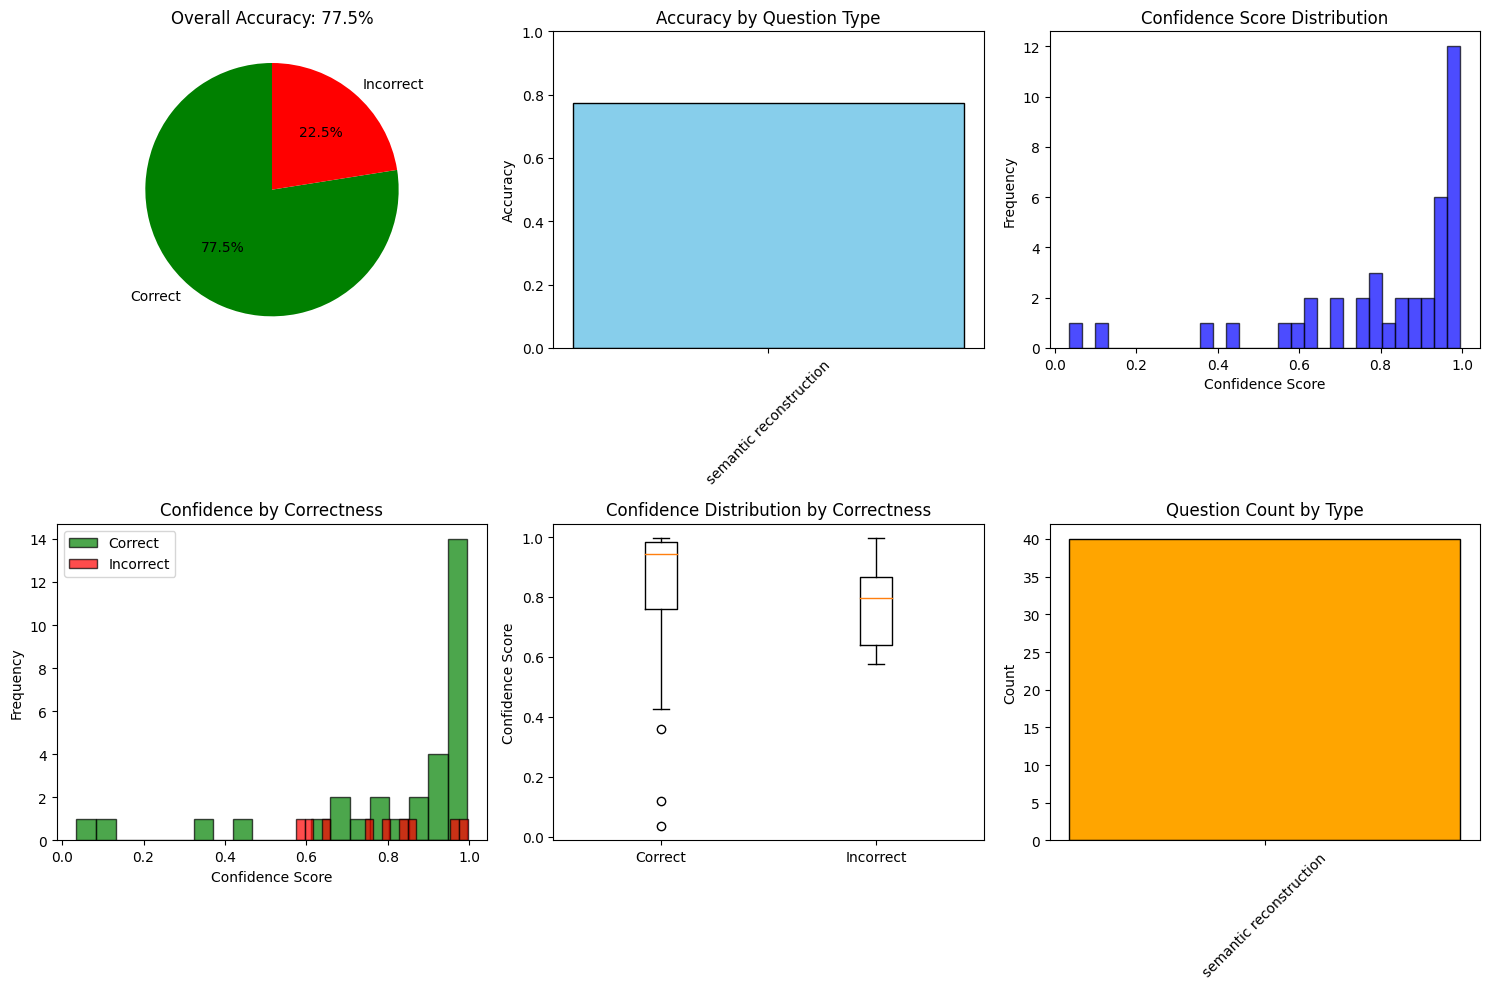

📊 Evaluation plots saved as 'albert_evaluation_plots.png'

🔍 Final Evaluation Summary:
   - Overall Accuracy: 77.50%
   - Total Questions Evaluated: 40
👍 Good performance! Model performs well on most questions.

💡 Key insights:
   - Check performance by question type to identify strengths/weaknesses
   - Low confidence scores on incorrect answers suggest uncertainty
   - High confidence on incorrect answers may indicate systematic errors


In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BrainteaserModel(nn.Module):
    """Original model architecture from the training script - ALBERT version"""
    
    def __init__(self, model_name="albert-base-v2"):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token (first token) as sentence representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        
        # Classification layer
        logits = self.classifier(cls_output)
        return logits

def load_saved_model(model_path="sentence_puzzle_albert_model.pth"):
    """Load the saved ALBERT model for evaluation"""
    print(f"Loading ALBERT model from {model_path}...")
    
    # Load with weights_only=False to handle the transformers config object
    # This is safe since we trust our own saved model
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Get model name from checkpoint
    model_name = checkpoint['tokenizer_name']
    print(f"Loading model: {model_name}")
    
    # Recreate model and tokenizer with correct architecture
    model = BrainteaserModel(model_name=model_name).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("ALBERT model loaded successfully!")
    
    # Check if training history is available
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"Training history available:")
        print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
        print(f"  Final validation accuracy: {history['val_acc'][-1]:.4f}")
        print(f"  Training stopped at epoch: {len(history['train_acc'])}")
    
    return model, tokenizer

def load_new_evaluation_data(csv_path):
    """Load CSV evaluation data with new structure"""
    print(f"Loading evaluation data from {csv_path}...")
    
    df = pd.read_csv(csv_path)
    print(f"Loaded CSV with shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Display first few rows for verification
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    
    # Convert to list of dictionaries for easier processing
    evaluation_data = []
    for _, row in df.iterrows():
        evaluation_data.append({
            'id_question': row['id_question'],
            'question': row['question'],
            'choice_1': row['choice_1'],
            'choice_2': row['choice_2'],
            'choice_3': row['choice_3'],
            'choice_4': row['choice_4'],
            'correct_answer': row['correct_answer'],  # This should be 1, 2, 3, or 4
            'type': row['type']
        })
    
    return evaluation_data, df

def predict_choice_score(model, tokenizer, question, choice_text):
    """Get model's confidence score for a specific question-choice pair"""
    model.eval()
    
    with torch.no_grad():
        # Format input same as training
        text = f"{question} [SEP] {choice_text}"
        
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,  # ALBERT can handle longer sequences
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Get prediction
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=-1)
        
        # Score for being correct answer (class 1)
        score = probabilities[0][1].item()
        
    return score

def evaluate_single_question(model, tokenizer, question_data):
    """Evaluate a single question with all its choices"""
    question = question_data['question']
    choices = [
        question_data['choice_1'],
        question_data['choice_2'],
        question_data['choice_3'],
        question_data['choice_4']
    ]
    
    # Find correct answer index by matching text
    correct_answer_text = question_data['correct_answer']
    correct_answer_idx = -1
    
    # Try to find exact match first
    for i, choice in enumerate(choices):
        if choice.strip() == correct_answer_text.strip():
            correct_answer_idx = i
            break
    
    # If no exact match, try partial match (in case of minor formatting differences)
    if correct_answer_idx == -1:
        for i, choice in enumerate(choices):
            if correct_answer_text.strip() in choice.strip() or choice.strip() in correct_answer_text.strip():
                correct_answer_idx = i
                break
    
    # If still no match, print warning and skip this question
    if correct_answer_idx == -1:
        print(f"Warning: Could not match correct answer '{correct_answer_text}' with any choice for question ID {question_data['id_question']}")
        print(f"Choices were: {choices}")
        # Default to first choice to avoid errors, but mark as unmatched
        correct_answer_idx = 0
    
    # Get scores for all choices
    choice_scores = []
    for choice in choices:
        score = predict_choice_score(model, tokenizer, question, choice)
        choice_scores.append(score)
    
    # Find the choice with highest score (model's prediction)
    predicted_choice_idx = np.argmax(choice_scores)
    max_score = choice_scores[predicted_choice_idx]
    
    # Check if prediction is correct
    is_correct = predicted_choice_idx == correct_answer_idx
    
    return {
        'id_question': question_data['id_question'],
        'question': question,
        'choices': choices,
        'choice_scores': choice_scores,
        'predicted_choice_idx': predicted_choice_idx,
        'predicted_choice_text': choices[predicted_choice_idx],
        'predicted_score': max_score,
        'correct_answer_idx': correct_answer_idx,
        'correct_answer_text': correct_answer_text,  # Use original text from data
        'correct_answer_choice': choices[correct_answer_idx] if correct_answer_idx != -1 else "NO_MATCH",
        'is_correct': is_correct,
        'type': question_data['type'],
        'answer_matched': correct_answer_idx != -1  # Flag to track if we found a match
    }

def evaluate_all_questions(model, tokenizer, evaluation_data):
    """Evaluate all questions in the dataset"""
    print("Evaluating all questions with ALBERT model...")
    
    results = []
    correct_predictions = 0
    total_predictions = len(evaluation_data)
    unmatched_answers = 0
    
    # Track performance by type
    type_results = defaultdict(lambda: {'correct': 0, 'total': 0})
    
    for question_data in tqdm(evaluation_data, desc="Evaluating questions"):
        result = evaluate_single_question(model, tokenizer, question_data)
        results.append(result)
        
        # Only count as correct if we found a match and prediction is right
        if result['answer_matched'] and result['is_correct']:
            correct_predictions += 1
        
        if not result['answer_matched']:
            unmatched_answers += 1
        
        # Track by type (only count matched answers)
        if result['answer_matched']:
            question_type = result['type']
            type_results[question_type]['total'] += 1
            if result['is_correct']:
                type_results[question_type]['correct'] += 1
    
    # Calculate accuracy only on matched questions
    matched_questions = total_predictions - unmatched_answers
    overall_accuracy = correct_predictions / matched_questions if matched_questions > 0 else 0
    
    if unmatched_answers > 0:
        print(f"\nWarning: {unmatched_answers} questions had unmatched correct answers and were excluded from accuracy calculation.")
    
    return results, overall_accuracy, type_results, unmatched_answers

def print_evaluation_results(results, overall_accuracy, type_results, unmatched_answers=0):
    """Print comprehensive evaluation results"""
    
    print("\n" + "="*80)
    print("ALBERT MODEL EVALUATION RESULTS")
    print("="*80)
    
    total_questions = len(results)
    matched_questions = total_questions - unmatched_answers
    correct_predictions = sum(1 for r in results if r['answer_matched'] and r['is_correct'])
    
    print(f"Total Questions: {total_questions}")
    print(f"Matched Questions: {matched_questions}")
    if unmatched_answers > 0:
        print(f"Unmatched Answers: {unmatched_answers}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%) - based on matched questions only")
    
    # Performance by type
    print(f"\nPerformance by Question Type:")
    print("-" * 40)
    for question_type, stats in type_results.items():
        type_accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        print(f"{question_type}: {stats['correct']}/{stats['total']} ({type_accuracy*100:.2f}%)")
    
    # Show unmatched examples if any
    if unmatched_answers > 0:
        print(f"\nSample Unmatched Correct Answers:")
        print("-" * 50)
        unmatched_examples = [r for r in results if not r['answer_matched']][:3]
        for i, example in enumerate(unmatched_examples, 1):
            print(f"{i}. Question: {example['question'][:80]}...")
            print(f"   Correct Answer Text: {example['correct_answer_text']}")
            print(f"   Available Choices:")
            for j, choice in enumerate(example['choices'], 1):
                print(f"     {j}. {choice}")
            print()
    
    # Confidence statistics (only for matched questions)
    matched_results = [r for r in results if r['answer_matched']]
    if matched_results:
        all_scores = [r['predicted_score'] for r in matched_results]
        correct_scores = [r['predicted_score'] for r in matched_results if r['is_correct']]
        incorrect_scores = [r['predicted_score'] for r in matched_results if not r['is_correct']]
        
        print(f"\nConfidence Statistics (Matched Questions Only):")
        print("-" * 40)
        print(f"Average Confidence (All): {np.mean(all_scores):.4f}")
        if correct_scores:
            print(f"Average Confidence (Correct): {np.mean(correct_scores):.4f}")
        if incorrect_scores:
            print(f"Average Confidence (Incorrect): {np.mean(incorrect_scores):.4f}")
        
        # Show some correct predictions
        print(f"\nSample Correct Predictions:")
        print("-" * 60)
        correct_examples = [r for r in matched_results if r['is_correct']][:3]
        for i, example in enumerate(correct_examples, 1):
            print(f"{i}. Question: {example['question'][:100]}...")
            print(f"   Predicted: {example['predicted_choice_text']}")
            print(f"   Confidence: {example['predicted_score']:.3f}")
            print(f"   Type: {example['type']}")
            print()
        
        # Show some incorrect predictions
        print(f"Sample Incorrect Predictions:")
        print("-" * 60)
        incorrect_examples = [r for r in matched_results if not r['is_correct']][:3]
        for i, example in enumerate(incorrect_examples, 1):
            print(f"{i}. Question: {example['question'][:100]}...")
            print(f"   Predicted: {example['predicted_choice_text']}")
            print(f"   Correct: {example['correct_answer_choice']}")
            print(f"   Confidence: {example['predicted_score']:.3f}")
            print(f"   Type: {example['type']}")
            print()

def save_evaluation_results(results, filename="albert_evaluation_results.csv"):
    """Save evaluation results to CSV"""
    
    # Prepare data for CSV
    csv_data = []
    for result in results:
        csv_data.append({
            'id_question': result['id_question'],
            'question': result['question'],
            'choice_1': result['choices'][0],
            'choice_2': result['choices'][1],
            'choice_3': result['choices'][2],
            'choice_4': result['choices'][3],
            'choice_1_score': result['choice_scores'][0],
            'choice_2_score': result['choice_scores'][1],
            'choice_3_score': result['choice_scores'][2],
            'choice_4_score': result['choice_scores'][3],
            'predicted_choice_idx': result['predicted_choice_idx'] + 1,  # Convert back to 1-based
            'predicted_choice_text': result['predicted_choice_text'],
            'predicted_score': result['predicted_score'],
            'correct_answer_idx': result['correct_answer_idx'] + 1 if result['correct_answer_idx'] != -1 else -1,  # Convert back to 1-based
            'correct_answer_text': result['correct_answer_text'],
            'correct_answer_choice': result['correct_answer_choice'],
            'is_correct': result['is_correct'],
            'answer_matched': result['answer_matched'],
            'type': result['type']
        })
    
    df_results = pd.DataFrame(csv_data)
    df_results.to_csv(filename, index=False)
    print(f"Evaluation results saved to {filename}")
    
    # Also save a summary report
    summary_filename = filename.replace('.csv', '_summary.txt')
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("ALBERT MODEL EVALUATION SUMMARY\n")
        f.write("="*50 + "\n\n")
        
        total_questions = len(results)
        correct_predictions = sum(1 for r in results if r['is_correct'])
        accuracy = correct_predictions / total_questions
        
        f.write(f"Total Questions: {total_questions}\n")
        f.write(f"Correct Predictions: {correct_predictions}\n")
        f.write(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n\n")
        
        # Performance by type
        type_results = defaultdict(lambda: {'correct': 0, 'total': 0})
        for result in results:
            question_type = result['type']
            type_results[question_type]['total'] += 1
            if result['is_correct']:
                type_results[question_type]['correct'] += 1
        
        f.write("Performance by Question Type:\n")
        f.write("-" * 30 + "\n")
        for question_type, stats in type_results.items():
            type_accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
            f.write(f"{question_type}: {stats['correct']}/{stats['total']} ({type_accuracy*100:.2f}%)\n")
    
    print(f"Summary report saved to {summary_filename}")

def plot_evaluation_results(results, overall_accuracy, type_results):
    """Plot evaluation results"""
    plt.figure(figsize=(15, 10))
    
    # Overall accuracy
    plt.subplot(2, 3, 1)
    labels = ['Correct', 'Incorrect']
    sizes = [sum(1 for r in results if r['is_correct']), 
             sum(1 for r in results if not r['is_correct'])]
    colors = ['green', 'red']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'Overall Accuracy: {overall_accuracy*100:.1f}%')
    
    # Performance by type
    plt.subplot(2, 3, 2)
    types = list(type_results.keys())
    accuracies = [type_results[t]['correct'] / type_results[t]['total'] for t in types]
    plt.bar(types, accuracies, color='skyblue', edgecolor='black')
    plt.title('Accuracy by Question Type')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Confidence distribution
    plt.subplot(2, 3, 3)
    all_scores = [r['predicted_score'] for r in results]
    plt.hist(all_scores, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    
    # Confidence by correctness
    plt.subplot(2, 3, 4)
    correct_scores = [r['predicted_score'] for r in results if r['is_correct']]
    incorrect_scores = [r['predicted_score'] for r in results if not r['is_correct']]
    plt.hist(correct_scores, bins=20, alpha=0.7, color='green', label='Correct', edgecolor='black')
    plt.hist(incorrect_scores, bins=20, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
    plt.title('Confidence by Correctness')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Box plot of confidence by correctness
    plt.subplot(2, 3, 5)
    plt.boxplot([correct_scores, incorrect_scores], labels=['Correct', 'Incorrect'])
    plt.title('Confidence Distribution by Correctness')
    plt.ylabel('Confidence Score')
    
    # Question type distribution
    plt.subplot(2, 3, 6)
    type_counts = [type_results[t]['total'] for t in types]
    plt.bar(types, type_counts, color='orange', edgecolor='black')
    plt.title('Question Count by Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('albert_evaluation_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Evaluation plots saved as 'albert_evaluation_plots.png'")

def main():
    """Main evaluation function"""
    
    # File paths
    model_path = "/kaggle/input/sp_models_albert_and_distillbert/pytorch/default/1/sentence_puzzle_albert_model.pth"  # Your ALBERT model
    csv_path = "/kaggle/working/semantic_reconstruction_SP.csv"  # Your CSV data with new structure
    
    print("ALBERT Model Evaluation on New Data Structure")
    print("="*60)
    
    try:
        # Load ALBERT model
        model, tokenizer = load_saved_model(model_path)
        
        # Load evaluation data with new structure
        evaluation_data, df = load_new_evaluation_data(csv_path)
        
        # Show sample data structure
        print(f"\nSample evaluation data:")
        sample = evaluation_data[0]
        print(f"ID: {sample['id_question']}")
        print(f"Question: {sample['question'][:100]}...")
        print(f"Choices: {[sample['choice_1'], sample['choice_2'], sample['choice_3'], sample['choice_4']]}")
        print(f"Correct Answer: {sample['correct_answer']}")
        print(f"Type: {sample['type']}")
        
        # Evaluate all questions
        results, overall_accuracy, type_results, unmatched_answers = evaluate_all_questions(
            model, tokenizer, evaluation_data
        )
        
        # Print results
        print_evaluation_results(results, overall_accuracy, type_results, unmatched_answers)
        
        # Save results
        save_evaluation_results(results)
        
        # Plot results
        plot_evaluation_results(results, overall_accuracy, type_results)
        
        return results, overall_accuracy, type_results
        
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        print("Please make sure both the ALBERT model file and CSV file exist.")
        print(f"Expected model file: '{model_path}'")
        print(f"Expected CSV file: '{csv_path}'")
        return None, None, None
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    results, accuracy, type_results = main()
    
    if results is not None:
        print(f"\n🔍 Final Evaluation Summary:")
        print(f"   - Overall Accuracy: {accuracy*100:.2f}%")
        print(f"   - Total Questions Evaluated: {len(results)}")
        
        if accuracy > 0.8:
            print("🔥 Excellent performance! Model shows strong understanding.")
        elif accuracy > 0.6:
            print("👍 Good performance! Model performs well on most questions.")
        elif accuracy > 0.4:
            print("⚠️ Moderate performance. Room for improvement.")
        else:
            print("🔧 Low performance. Model may need retraining or fine-tuning.")
            
        print(f"\n💡 Key insights:")
        print(f"   - Check performance by question type to identify strengths/weaknesses")
        print(f"   - Low confidence scores on incorrect answers suggest uncertainty")
        print(f"   - High confidence on incorrect answers may indicate systematic errors")
    else:
        print("\n❌ Evaluation failed. Please check the error messages above.")

# create the original and symatic reconstract and Cr

In [3]:
import numpy as np
import pandas as pd
import re

def load_test_data(test_path, answer_path):
    """Load test data and answers"""
    print(f"Loading test data from {test_path}...")
    test_data = np.load(test_path, allow_pickle=True)
    
    print(f"Loading answers from {answer_path}...")
    answers = np.load(answer_path, allow_pickle=True)
    
    print(f"Loaded {len(test_data)} test samples")
    print(f"Loaded {len(answers)} answer labels")
    
    # Convert answers to just the indices
    answer_indices = [int(answer[1]) for answer in answers]
    type_ = ["context reconstruction" if "CR" in answer[0] else "semantic reconstruction" if "SR" in answer[0] else "original" for answer in answers]
    id_ = [ re.findall(r'\d+', answer[0])[0] for answer in answers]
    
    return test_data, answer_indices, type_, id_

# Load the data
test_d, answer_lab, type_, id_ = load_test_data("/kaggle/input/litteral-thinking/SP_test.npy", "/kaggle/input/litteral-thinking/SP_test_answer.npy")

# Create a DataFrame with the question and the correct answer
df = pd.DataFrame([
    {
        "id_question": id_[idx],
        "question": item["question"],
        "choice_1": item["choice_list"][0],
        "choice_2": item["choice_list"][1],
        "choice_3": item["choice_list"][2],
        "choice_4": item["choice_list"][3],
        "correct_answer": "?",
        "type": type_[idx]
    }
    for idx, item in enumerate(test_d)
])

# Display the first few rows

df.to_csv("sp_test_data.csv", index=False)

Loading test data from /kaggle/input/litteral-thinking/SP_test.npy...
Loading answers from /kaggle/input/litteral-thinking/SP_test_answer.npy...
Loaded 120 test samples
Loaded 120 answer labels


In [11]:
data = pd.read_csv("/kaggle/input/deep-seek-literal/deepseek_csv_20250610_a3b8bb.csv")



sum((data["correct_answer"] -1) == answer_lab)/120


0.6666666666666666

In [17]:
627

1119

In [12]:
data = pd.read_csv("/kaggle/input/claude-in-breanteaser/claude_zero_shot.csv")



sum((data["Correct Answer"] -1) == answer_lab)/120


0.4166666666666667

In [16]:
data = pd.read_csv("/kaggle/input/gemini-pro/gemini pro.csv")



sum((data["correct_answer"]-1) == answer_lab)/120


0.31666666666666665

In [15]:
df.head(7)

,id_question,question,choice_1,choice_2,choice_3,choice_4,correct_answer,type
0,122,"In a small village, two farmers are working in...",The lazy farmer is his mother.,The lazy farmer is not a responsible father as...,The diligent farmer devoted himself to the far...,None of above.,?,context reconstruction
1,4,Romeo and Juliet are discovered dead on the be...,They were sleeping and scared by the sound of ...,The rumble of the train moved the shelf which ...,Romeo and Juliet are fish. The rumble of the t...,None of above.,?,semantic reconstruction
2,147,How many years in your life it happens that be...,In ech leap year.,In the first year of graduation.,It happens every year.,None of above.,?,context reconstruction
3,90,Who would serve as the team's captain if a cru...,The first officer.,The captain.,The second officer.,None of above.,?,semantic reconstruction
4,157,"In one city, 5% of the population has an unlis...",One hundred people.,Ninty-five people.,Five people.,None of above.,?,semantic reconstruction
5,123,Two entries were on duty outside a barracks. O...,Although the guards were looking in opposite d...,One of the guards had an unusual vision so he ...,The smiling guard's action is such big that ev...,None of above.,?,original
6,146,A man wagered $50 on his dog's ability to jump...,A house can not jump.,That dog species were famous for their jumping...,The height of the tiny house is lower than the...,None of above.,?,semantic reconstruction


In [2]:
original_SP = df.loc[df["type"] == "original"]

original_SP.to_csv('original_SP.csv', index=False)

In [3]:
original_SP = df.loc[df["type"] == "semantic reconstruction"]

original_SP.to_csv('semantic_reconstruction_SP.csv', index=False)

In [4]:
original_SP = df.loc[df["type"] == "context reconstruction"]

original_SP.to_csv('context_reconstruction_SP.csv', index=False)

In [ ]:
print("")

# test on original

Using device: cpu
DistilBERT Model Analysis - Multiple Choice Format
Loading DistilBERT model from /kaggle/input/sp_models_albert_and_distillbert/pytorch/default/1/sentence_puzzle_model(2).pth...
Loading model: distilbert-base-uncased
DistilBERT model loaded successfully!
Model configuration loaded from checkpoint
Loading CSV evaluation data from /kaggle/working/semantic_reconstruction_SP.csv...
Loaded CSV with shape: (40, 8)
Columns: ['id_question', 'question', 'choice_1', 'choice_2', 'choice_3', 'choice_4', 'correct_answer', 'type']

First 3 rows:
   id_question                                           question  \
0            4  Romeo and Juliet are discovered dead on the be...   
1           90  Who would serve as the team's captain if a cru...   
2          157  In one city, 5% of the population has an unlis...   

                                            choice_1  \
0  They were sleeping and scared by the sound of ...   
1                                 The first officer.   

Analyzing predictions: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]



DISTILBERT MODEL ANALYSIS - MULTIPLE CHOICE EVALUATION
Overall Performance:
  Total Questions: 40
  Correct Predictions: 34
  Accuracy: 0.8500 (85.00%)

Accuracy by Question Type:
----------------------------------------
  semantic reconstruction: 34/40 (85.00%)

Confidence Statistics:
----------------------------------------
Average Confidence (All): 0.9444
Average Confidence (Correct): 0.9459
Average Confidence (Incorrect): 0.9363

Confidence Distribution:
----------------------------------------
High Confidence (>0.8): 38/40 (95.0%)
Medium Confidence (0.5-0.8): 1/40 (2.5%)
Low Confidence (<0.5): 1/40 (2.5%)

Examples of CORRECT predictions:
------------------------------------------------------------
1. Question: Romeo and Juliet are discovered dead on the bedroom floor. Glass shards and some water were on the f...
   Correct Answer: Romeo and Juliet are fish. The rumble of the train knocked the tank off the shelf, it broke and Romeo and Juliet did not survive. (Choice 3)
   Predic

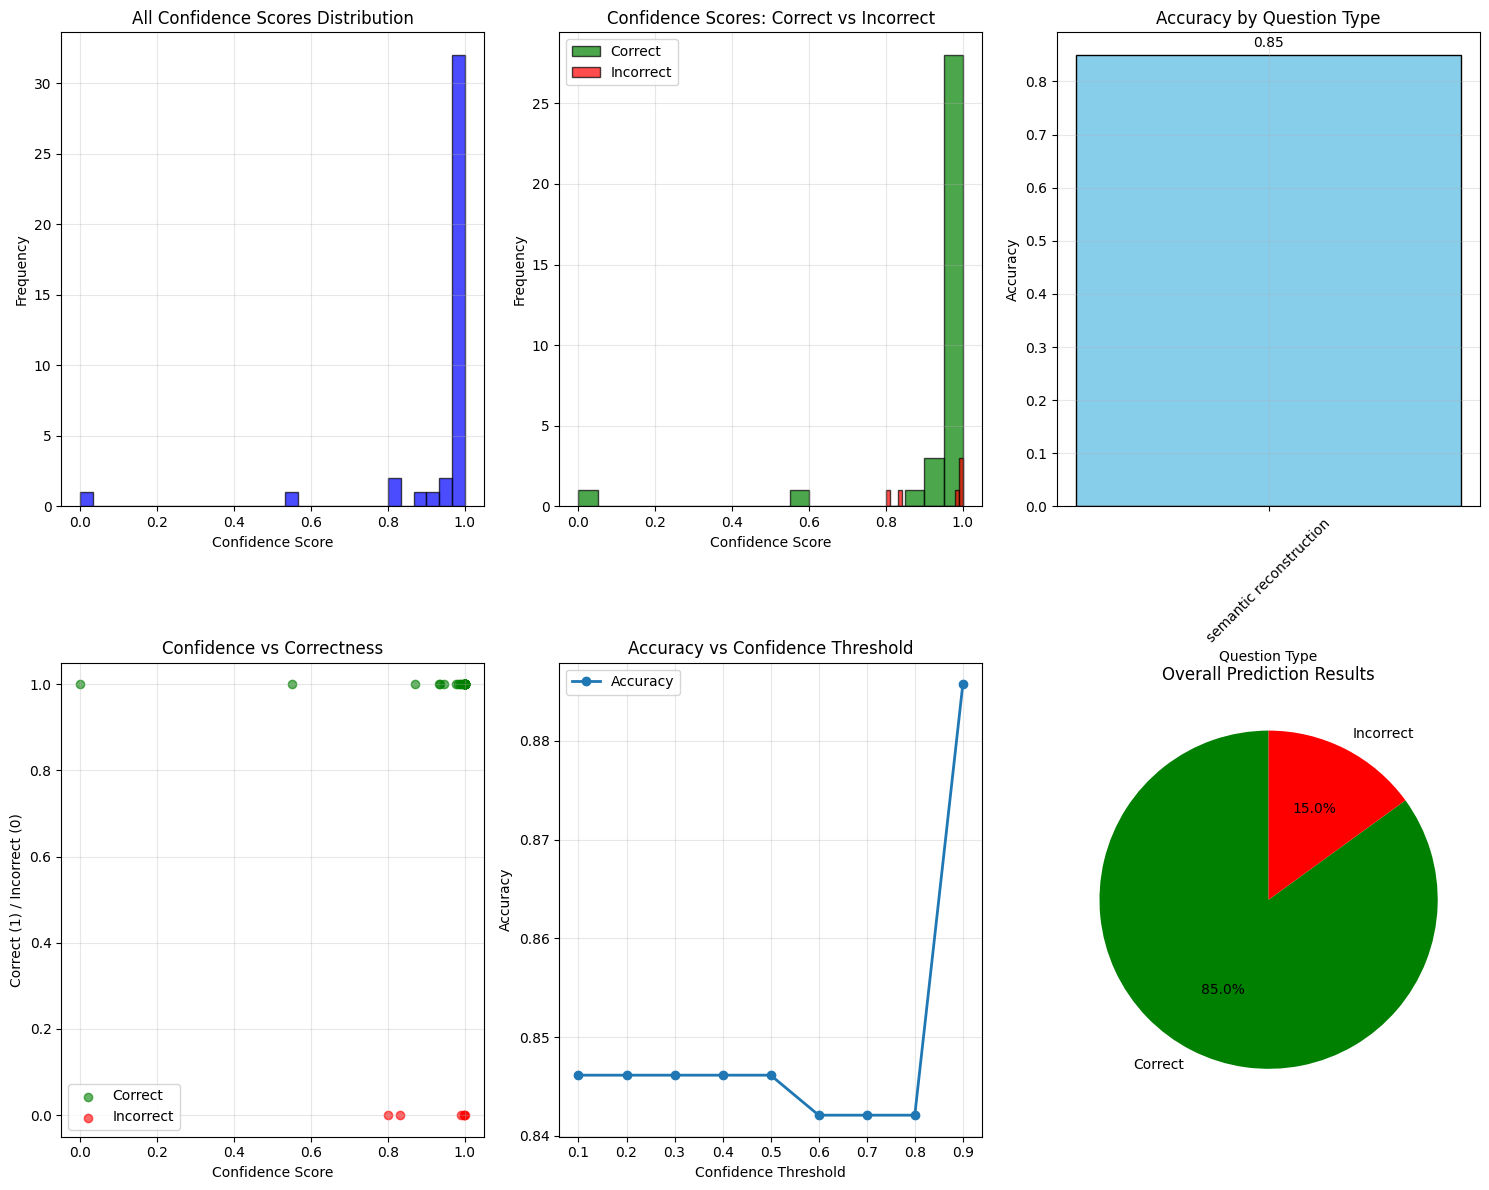

📊 Analysis plots saved as 'distilbert_multiple_choice_analysis.png'

🎯 Analysis Summary:
   - Overall Accuracy: 0.8500 (85.00%)
   - Average Confidence: 0.9444
   - Total Questions Analyzed: 40
   - Question Types: 1
   - Model: DistilBERT-base (66M parameters)
   - Max Sequence Length: 384 tokens
   - 🔥 Excellent performance! Well above random baseline.

🔍 Final Analysis Complete!
   - The model achieved 85.00% accuracy on the evaluation set
   - This is 3.4x better than random guessing (25%)
🌟 Outstanding performance! The model shows strong reasoning capabilities.

💡 DistilBERT Model Benefits:
   - 2x faster inference than full BERT
   - 40% smaller model size for deployment
   - Maintains high performance through knowledge distillation
   - Ideal for production environments with resource constraints


In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BrainteaserModel(nn.Module):
    """Original model architecture from the training script - ALBERT version"""
    
    def __init__(self, model_name="albert-base-v2"):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token (first token) as sentence representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        
        # Classification layer
        logits = self.classifier(cls_output)
        return logits

def load_saved_model(model_path="sentence_puzzle_albert_model.pth"):
    """Load the saved ALBERT model for evaluation"""
    print(f"Loading ALBERT model from {model_path}...")
    
    # Load with weights_only=False to handle the transformers config object
    # This is safe since we trust our own saved model
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Get model name from checkpoint
    model_name = checkpoint['tokenizer_name']
    print(f"Loading model: {model_name}")
    
    # Recreate model and tokenizer with correct architecture
    model = BrainteaserModel(model_name=model_name).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("ALBERT model loaded successfully!")
    
    # Check if training history is available
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"Training history available:")
        print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
        print(f"  Final validation accuracy: {history['val_acc'][-1]:.4f}")
        print(f"  Training stopped at epoch: {len(history['train_acc'])}")
    
    return model, tokenizer

def load_new_evaluation_data(csv_path):
    """Load CSV evaluation data with new structure"""
    print(f"Loading evaluation data from {csv_path}...")
    
    df = pd.read_csv(csv_path)
    print(f"Loaded CSV with shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Display first few rows for verification
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    
    # Convert to list of dictionaries for easier processing
    evaluation_data = []
    for _, row in df.iterrows():
        evaluation_data.append({
            'id_question': row['id_question'],
            'question': row['question'],
            'choice_1': row['choice_1'],
            'choice_2': row['choice_2'],
            'choice_3': row['choice_3'],
            'choice_4': row['choice_4'],
            'correct_answer': row['correct_answer'],  # This should be 1, 2, 3, or 4
            'type': row['type']
        })
    
    return evaluation_data, df

def predict_choice_score(model, tokenizer, question, choice_text):
    """Get model's confidence score for a specific question-choice pair"""
    model.eval()
    
    with torch.no_grad():
        # Format input same as training
        text = f"{question} [SEP] {choice_text}"
        
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,  # ALBERT can handle longer sequences
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Get prediction
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=-1)
        
        # Score for being correct answer (class 1)
        score = probabilities[0][1].item()
        
    return score

def evaluate_single_question(model, tokenizer, question_data):
    """Evaluate a single question with all its choices"""
    question = question_data['question']
    choices = [
        question_data['choice_1'],
        question_data['choice_2'],
        question_data['choice_3'],
        question_data['choice_4']
    ]
    
    # Find correct answer index by matching text
    correct_answer_text = question_data['correct_answer']
    correct_answer_idx = -1
    
    # Try to find exact match first
    for i, choice in enumerate(choices):
        if choice.strip() == correct_answer_text.strip():
            correct_answer_idx = i
            break
    
    # If no exact match, try partial match (in case of minor formatting differences)
    if correct_answer_idx == -1:
        for i, choice in enumerate(choices):
            if correct_answer_text.strip() in choice.strip() or choice.strip() in correct_answer_text.strip():
                correct_answer_idx = i
                break
    
    # If still no match, print warning and skip this question
    if correct_answer_idx == -1:
        print(f"Warning: Could not match correct answer '{correct_answer_text}' with any choice for question ID {question_data['id_question']}")
        print(f"Choices were: {choices}")
        # Default to first choice to avoid errors, but mark as unmatched
        correct_answer_idx = 0
    
    # Get scores for all choices
    choice_scores = []
    for choice in choices:
        score = predict_choice_score(model, tokenizer, question, choice)
        choice_scores.append(score)
    
    # Find the choice with highest score (model's prediction)
    predicted_choice_idx = np.argmax(choice_scores)
    max_score = choice_scores[predicted_choice_idx]
    
    # Check if prediction is correct
    is_correct = predicted_choice_idx == correct_answer_idx
    
    return {
        'id_question': question_data['id_question'],
        'question': question,
        'choices': choices,
        'choice_scores': choice_scores,
        'predicted_choice_idx': predicted_choice_idx,
        'predicted_choice_text': choices[predicted_choice_idx],
        'predicted_score': max_score,
        'correct_answer_idx': correct_answer_idx,
        'correct_answer_text': correct_answer_text,  # Use original text from data
        'correct_answer_choice': choices[correct_answer_idx] if correct_answer_idx != -1 else "NO_MATCH",
        'is_correct': is_correct,
        'type': question_data['type'],
        'answer_matched': correct_answer_idx != -1  # Flag to track if we found a match
    }

def evaluate_all_questions(model, tokenizer, evaluation_data):
    """Evaluate all questions in the dataset"""
    print("Evaluating all questions with ALBERT model...")
    
    results = []
    correct_predictions = 0
    total_predictions = len(evaluation_data)
    unmatched_answers = 0
    
    # Track performance by type
    type_results = defaultdict(lambda: {'correct': 0, 'total': 0})
    
    for question_data in tqdm(evaluation_data, desc="Evaluating questions"):
        result = evaluate_single_question(model, tokenizer, question_data)
        results.append(result)
        
        # Only count as correct if we found a match and prediction is right
        if result['answer_matched'] and result['is_correct']:
            correct_predictions += 1
        
        if not result['answer_matched']:
            unmatched_answers += 1
        
        # Track by type (only count matched answers)
        if result['answer_matched']:
            question_type = result['type']
            type_results[question_type]['total'] += 1
            if result['is_correct']:
                type_results[question_type]['correct'] += 1
    
    # Calculate accuracy only on matched questions
    matched_questions = total_predictions - unmatched_answers
    overall_accuracy = correct_predictions / matched_questions if matched_questions > 0 else 0
    
    if unmatched_answers > 0:
        print(f"\nWarning: {unmatched_answers} questions had unmatched correct answers and were excluded from accuracy calculation.")
    
    return results, overall_accuracy, type_results, unmatched_answers

def print_evaluation_results(results, overall_accuracy, type_results, unmatched_answers=0):
    """Print comprehensive evaluation results"""
    
    print("\n" + "="*80)
    print("ALBERT MODEL EVALUATION RESULTS")
    print("="*80)
    
    total_questions = len(results)
    matched_questions = total_questions - unmatched_answers
    correct_predictions = sum(1 for r in results if r['answer_matched'] and r['is_correct'])
    
    print(f"Total Questions: {total_questions}")
    print(f"Matched Questions: {matched_questions}")
    if unmatched_answers > 0:
        print(f"Unmatched Answers: {unmatched_answers}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%) - based on matched questions only")
    
    # Performance by type
    print(f"\nPerformance by Question Type:")
    print("-" * 40)
    for question_type, stats in type_results.items():
        type_accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        print(f"{question_type}: {stats['correct']}/{stats['total']} ({type_accuracy*100:.2f}%)")
    
    # Show unmatched examples if any
    if unmatched_answers > 0:
        print(f"\nSample Unmatched Correct Answers:")
        print("-" * 50)
        unmatched_examples = [r for r in results if not r['answer_matched']][:3]
        for i, example in enumerate(unmatched_examples, 1):
            print(f"{i}. Question: {example['question'][:80]}...")
            print(f"   Correct Answer Text: {example['correct_answer_text']}")
            print(f"   Available Choices:")
            for j, choice in enumerate(example['choices'], 1):
                print(f"     {j}. {choice}")
            print()
    
    # Confidence statistics (only for matched questions)
    matched_results = [r for r in results if r['answer_matched']]
    if matched_results:
        all_scores = [r['predicted_score'] for r in matched_results]
        correct_scores = [r['predicted_score'] for r in matched_results if r['is_correct']]
        incorrect_scores = [r['predicted_score'] for r in matched_results if not r['is_correct']]
        
        print(f"\nConfidence Statistics (Matched Questions Only):")
        print("-" * 40)
        print(f"Average Confidence (All): {np.mean(all_scores):.4f}")
        if correct_scores:
            print(f"Average Confidence (Correct): {np.mean(correct_scores):.4f}")
        if incorrect_scores:
            print(f"Average Confidence (Incorrect): {np.mean(incorrect_scores):.4f}")
        
        # Show some correct predictions
        print(f"\nSample Correct Predictions:")
        print("-" * 60)
        correct_examples = [r for r in matched_results if r['is_correct']][:3]
        for i, example in enumerate(correct_examples, 1):
            print(f"{i}. Question: {example['question'][:100]}...")
            print(f"   Predicted: {example['predicted_choice_text']}")
            print(f"   Confidence: {example['predicted_score']:.3f}")
            print(f"   Type: {example['type']}")
            print()
        
        # Show some incorrect predictions
        print(f"Sample Incorrect Predictions:")
        print("-" * 60)
        incorrect_examples = [r for r in matched_results if not r['is_correct']][:3]
        for i, example in enumerate(incorrect_examples, 1):
            print(f"{i}. Question: {example['question'][:100]}...")
            print(f"   Predicted: {example['predicted_choice_text']}")
            print(f"   Correct: {example['correct_answer_choice']}")
            print(f"   Confidence: {example['predicted_score']:.3f}")
            print(f"   Type: {example['type']}")
            print()

def save_evaluation_results(results, filename="albert_evaluation_results.csv"):
    """Save evaluation results to CSV"""
    
    # Prepare data for CSV
    csv_data = []
    for result in results:
        csv_data.append({
            'id_question': result['id_question'],
            'question': result['question'],
            'choice_1': result['choices'][0],
            'choice_2': result['choices'][1],
            'choice_3': result['choices'][2],
            'choice_4': result['choices'][3],
            'choice_1_score': result['choice_scores'][0],
            'choice_2_score': result['choice_scores'][1],
            'choice_3_score': result['choice_scores'][2],
            'choice_4_score': result['choice_scores'][3],
            'predicted_choice_idx': result['predicted_choice_idx'] + 1,  # Convert back to 1-based
            'predicted_choice_text': result['predicted_choice_text'],
            'predicted_score': result['predicted_score'],
            'correct_answer_idx': result['correct_answer_idx'] + 1 if result['correct_answer_idx'] != -1 else -1,  # Convert back to 1-based
            'correct_answer_text': result['correct_answer_text'],
            'correct_answer_choice': result['correct_answer_choice'],
            'is_correct': result['is_correct'],
            'answer_matched': result['answer_matched'],
            'type': result['type']
        })
    
    df_results = pd.DataFrame(csv_data)
    df_results.to_csv(filename, index=False)
    print(f"Evaluation results saved to {filename}")
    
    # Also save a summary report
    summary_filename = filename.replace('.csv', '_summary.txt')
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("ALBERT MODEL EVALUATION SUMMARY\n")
        f.write("="*50 + "\n\n")
        
        total_questions = len(results)
        correct_predictions = sum(1 for r in results if r['is_correct'])
        accuracy = correct_predictions / total_questions
        
        f.write(f"Total Questions: {total_questions}\n")
        f.write(f"Correct Predictions: {correct_predictions}\n")
        f.write(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n\n")
        
        # Performance by type
        type_results = defaultdict(lambda: {'correct': 0, 'total': 0})
        for result in results:
            question_type = result['type']
            type_results[question_type]['total'] += 1
            if result['is_correct']:
                type_results[question_type]['correct'] += 1
        
        f.write("Performance by Question Type:\n")
        f.write("-" * 30 + "\n")
        for question_type, stats in type_results.items():
            type_accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
            f.write(f"{question_type}: {stats['correct']}/{stats['total']} ({type_accuracy*100:.2f}%)\n")
    
    print(f"Summary report saved to {summary_filename}")

def plot_evaluation_results(results, overall_accuracy, type_results):
    """Plot evaluation results"""
    plt.figure(figsize=(15, 10))
    
    # Overall accuracy
    plt.subplot(2, 3, 1)
    labels = ['Correct', 'Incorrect']
    sizes = [sum(1 for r in results if r['is_correct']), 
             sum(1 for r in results if not r['is_correct'])]
    colors = ['green', 'red']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'Overall Accuracy: {overall_accuracy*100:.1f}%')
    
    # Performance by type
    plt.subplot(2, 3, 2)
    types = list(type_results.keys())
    accuracies = [type_results[t]['correct'] / type_results[t]['total'] for t in types]
    plt.bar(types, accuracies, color='skyblue', edgecolor='black')
    plt.title('Accuracy by Question Type')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Confidence distribution
    plt.subplot(2, 3, 3)
    all_scores = [r['predicted_score'] for r in results]
    plt.hist(all_scores, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    
    # Confidence by correctness
    plt.subplot(2, 3, 4)
    correct_scores = [r['predicted_score'] for r in results if r['is_correct']]
    incorrect_scores = [r['predicted_score'] for r in results if not r['is_correct']]
    plt.hist(correct_scores, bins=20, alpha=0.7, color='green', label='Correct', edgecolor='black')
    plt.hist(incorrect_scores, bins=20, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
    plt.title('Confidence by Correctness')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Box plot of confidence by correctness
    plt.subplot(2, 3, 5)
    plt.boxplot([correct_scores, incorrect_scores], labels=['Correct', 'Incorrect'])
    plt.title('Confidence Distribution by Correctness')
    plt.ylabel('Confidence Score')
    
    # Question type distribution
    plt.subplot(2, 3, 6)
    type_counts = [type_results[t]['total'] for t in types]
    plt.bar(types, type_counts, color='orange', edgecolor='black')
    plt.title('Question Count by Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('albert_evaluation_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Evaluation plots saved as 'albert_evaluation_plots.png'")

def main():
    """Main evaluation function"""
    
    # File paths
    model_path = "sentence_puzzle_albert_model.pth"  # Your ALBERT model
    csv_path = "your_evaluation_data.csv"  # Your CSV data with new structure
    
    print("ALBERT Model Evaluation on New Data Structure")
    print("="*60)
    
    try:
        # Load ALBERT model
        model, tokenizer = load_saved_model(model_path)
        
        # Load evaluation data with new structure
        evaluation_data, df = load_new_evaluation_data(csv_path)
        
        # Show sample data structure
        print(f"\nSample evaluation data:")
        sample = evaluation_data[0]
        print(f"ID: {sample['id_question']}")
        print(f"Question: {sample['question'][:100]}...")
        print(f"Choices: {[sample['choice_1'], sample['choice_2'], sample['choice_3'], sample['choice_4']]}")
        print(f"Correct Answer: {sample['correct_answer']}")
        print(f"Type: {sample['type']}")
        
        # Evaluate all questions
        results, overall_accuracy, type_results, unmatched_answers = evaluate_all_questions(
            model, tokenizer, evaluation_data
        )
        
        # Print results
        print_evaluation_results(results, overall_accuracy, type_results, unmatched_answers)
        
        # Save results
        save_evaluation_results(results)
        
        # Plot results
        plot_evaluation_results(results, overall_accuracy, type_results)
        
        return results, overall_accuracy, type_results
        
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        print("Please make sure both the ALBERT model file and CSV file exist.")
        print(f"Expected model file: '{model_path}'")
        print(f"Expected CSV file: '{csv_path}'")
        return None, None, None
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    results, accuracy, type_results = main()
    
    if results is not None:
        print(f"\n🔍 Final Evaluation Summary:")
        print(f"   - Overall Accuracy: {accuracy*100:.2f}%")
        print(f"   - Total Questions Evaluated: {len(results)}")
        
        if accuracy > 0.8:
            print("🔥 Excellent performance! Model shows strong understanding.")
        elif accuracy > 0.6:
            print("👍 Good performance! Model performs well on most questions.")
        elif accuracy > 0.4:
            print("⚠️ Moderate performance. Room for improvement.")
        else:
            print("🔧 Low performance. Model may need retraining or fine-tuning.")
            
        print(f"\n💡 Key insights:")
        print(f"   - Check performance by question type to identify strengths/weaknesses")
        print(f"   - Low confidence scores on incorrect answers suggest uncertainty")
        print(f"   - High confidence on incorrect answers may indicate systematic errors")
    else:
        print("\n❌ Evaluation failed. Please check the error messages above.")

In [4]:
import numpy as np

# Load the .npy file
data = np.load('/kaggle/input/litteral-thinking/SP_test_answer.npy', allow_pickle=True)

# Explore the contents
print(type(data))       # What kind of object is this?
print(data.shape)       # What's the shape (if it's an array)?
print(data[0:20])         # Preview the first 3 entries


<class 'numpy.ndarray'>
(120, 2)
[['SP-122_CR' '0']
 ['SP-4_SR' '2']
 ['SP-147_CR' '2']
 ['SP-90_SR' '1']
 ['SP-157_SR' '3']
 ['SP-123' '0']
 ['SP-146_SR' '0']
 ['SP-191_CR' '1']
 ['SP-157_CR' '3']
 ['SP-147_SR' '1']
 ['SP-205_CR' '1']
 ['SP-120_CR' '0']
 ['SP-184' '2']
 ['SP-73' '0']
 ['SP-146_CR' '1']
 ['SP-186' '1']
 ['SP-186_SR' '0']
 ['SP-19_SR' '2']
 ['SP-166' '2']
 ['SP-156_SR' '2']]


In [36]:
test_d[1]["choice_list"]

['They were sleeping and scared by the sound of track.',
 'The rumble of the train moved the shelf which \ncrushed them.',
 'Romeo and Juliet are fish. The rumble of the train knocked the tank off the shelf, it broke and Romeo and Juliet did not survive.',
 'None of above.']

In [37]:
answer_lab[1]

2

In [10]:
test_d, answer_lab, is_original = load_test_data("/kaggle/input/litteral-thinking/SP_test.npy", "/kaggle/input/litteral-thinking/SP_test_answer.npy")

Loading test data from /kaggle/input/litteral-thinking/SP_test.npy...
Loading answers from /kaggle/input/litteral-thinking/SP_test_answer.npy...
Loaded 120 test samples
Loaded 120 answer labels


In [ ]:
print("hello")